# Global renewable energy analysis - Hypothesis testing

**Objective**
In this notebook we will provide deeper insight towards satisfying the business requirements of understanding global trends in renewable energy. We will do this by testing specific hypotheses outlined below using a combination of advanced visualisations and machine learning techniques.

**Hypotheses**
- **H1:** Historical growth in renewables is linked to a country's gross domestic product (GDP). Countries with higher GDP have slower growth in fossil fuel consumption (they already peaked) and faster growth in renewables. In contrast, emerging economies (those with lower GDP) still show strong growth in fossil fuel consumption.

- **H2:** Leaders and laggers in the green energy transition. Renewable production has increased over the last decade, accelerating the transition to green energy. The rate of this growth varies geographically, with some countries leading the way in the green energy transition and other countries falling behind.

- **H3:** Renewables have been rising over the last two decades, with growth in some renewables like solar and wind especially fast in the last 10 years. Production of renewables will continue to increase over the next ten years, accelerating the shift from fossil to green energy. 

**Input**
- Cleaned dataset of energy production and consumption from 1982-2022 per country ('world_energy_consumption_cleaned.csv') 
- Five-year summary (2018-2022) of energy production and consumption (average and total) per country ('world_energy_consumption_last5_summary.csv')

**Output**
Forecast models per renewable energy type:
- 'lstm_biofuel_forecast.pth'
- 'lstm_hydro_forecast.pth'
- 'lstm_nuclear_forecast.pth'
- 'lstm_solar_forecast.pth'
- 'lstm_wind_forecast.pth'


## Load data and libraries

In [2]:
#import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import plotly.express as px

In [3]:
#Check working directory
#change to correct directory if needed
os.chdir('c:\\Users\\User\\OneDrive\\Documents\\Code Institute Data Analytics and AI\\Capstone project - renewables\\global_renewable_energy_analysis')
current_dir = os.getcwd()
current_dir #show cwd

'c:\\Users\\User\\OneDrive\\Documents\\Code Institute Data Analytics and AI\\Capstone project - renewables\\global_renewable_energy_analysis'

In [4]:
#load data
df = pd.read_csv('./data/world_energy_consumption_cleaned.csv')
df_last5 = pd.read_csv('./data/world_energy_consumption_last5_summary.csv')
df.head()

,country,iso_code,year,population,gdp,continent,sub_region,per_capita_electricity,energy_per_capita,energy_per_gdp,...,renewables_elec_per_capita,renewables_energy_per_capita,renewables_cons_change_pct,renewables_share_energy,renewables_share_elec,fossil_elec_per_capita,fossil_energy_per_capita,fossil_cons_change_pct,fossil_share_energy,fossil_share_elec
0,Afghanistan,AFG,1982,10088290.0,1.598041e+10,Asia,Southern Asia,NaN,926.651,0.585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,1983,9951447.0,1.675533e+10,Asia,Southern Asia,NaN,1149.196,0.683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1984,10243689.0,1.707215e+10,Asia,Southern Asia,NaN,1121.573,0.673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,1985,10512220.0,1.710848e+10,Asia,Southern Asia,NaN,1067.071,0.656,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,1986,10448447.0,1.764135e+10,Asia,Southern Asia,NaN,1097.040,0.650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## H1: Historical trends

Historical growth in renewables is linked to a country's gross domestic product (GDP). Countries with higher GDP have slower growth in fossil fuel consumption (they already peaked) and faster growth in renewables. In contrast, emerging economies (those with lower GDP) still show strong growth in fossil fuel consumption.

Prediction: fossil fuel growth (percentage annual change) will show a negative relationship with GDP, while growth in renewables (percentage annual change) will show a positive relationship with GDP.

Let's plot percentage annual growth in renewables and fossil fuels against GDP per country (averages over the last 5 years). We will add in a global average as a baseline for comparison.

In [4]:
# Get global average for last 5 years in percent growth and gdp columns
global_avg = df[df['year']>=2018][['renewables_cons_change_pct', 'fossil_cons_change_pct', 'gdp']].mean().rename(index={
    'renewables_cons_change_pct': 'renewables_cons_change_pct_mean',
    'fossil_cons_change_pct': 'fossil_cons_change_pct_mean',
    'gdp': 'gdp_mean'
}).to_frame().T

global_avg['country_'] = 'Global'#add country_ column with value 'Global'
#global_avg

# extract the same columns from df_last5 for plotting
df_last5_plot = df_last5[['country_', 'renewables_cons_change_pct_mean', 'fossil_cons_change_pct_mean', 'gdp_mean']]
#append global average row to df_last5_plot
df_last5_plot = pd.concat([df_last5_plot, global_avg], ignore_index=True)
df_last5_plot['country_'].value_counts()


country_
Afghanistan    1
Palestine      1
New Zealand    1
Nicaragua      1
Niger          1
              ..
Gibraltar      1
Greece         1
Greenland      1
Grenada        1
Global         1
Name: count, Length: 217, dtype: int64

### Fossil fuel growth vs GDP

In [21]:
#plot fossil fuel consumption change pct vs gdp

# Get the 'Global' datapoint
global_row = df_last5_plot[df_last5_plot['country_'] == 'Global'].iloc[0]
global_gdp = global_row['gdp_mean']
global_fossil = global_row['fossil_cons_change_pct_mean']

fig = px.scatter(
    df_last5_plot,
    x='gdp_mean',
    y='fossil_cons_change_pct_mean',
    hover_name='country_',
    title='Growth in Fossil Fuel Consumption vs GDP per country (averaged over last 5 years)',
    labels={
        'gdp_mean': 'GDP (log-transformed)',
        'fossil_cons_change_pct_mean': 'Percentage growth in fossil fuel consumption'
    },
    log_x=True,
    trendline='ols',
    template='plotly_white',
    symbol=df_last5_plot['country_'].apply(lambda x: 'star' if x == 'Global' else 'circle'),
    color=df_last5_plot['country_'].apply(lambda x: 'red' if x == 'Global' else 'blue'),
)

# Add horizontal and vertical lines for the 'Global' datapoint
fig.add_vline(x=global_gdp, line_dash="dash", line_color="red", annotation_text="Global GDP", annotation_position="top left")
fig.add_hline(y=global_fossil, line_dash="dash", line_color="red", annotation_text="Global Fossil Growth", annotation_position="bottom right")

fig.update_layout(showlegend=False)  # Remove legend

fig.show()

#ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed
#update package and restart kernel

Now let's test this relationship with an OLS regression analysis. We'll use the dataset without the 'global' datapoint as this isn't a real value we want to include.

Fit the model:

In [27]:
#regression analysis of fossil fuel consumption change pct vs gdp

#first we need to log-transform the gdp values
df_last5['gdp_mean_log'] = np.log(df_last5['gdp_mean'])
df_h1_test = df_last5.dropna(subset=['fossil_cons_change_pct_mean', 'gdp_mean_log'])

#perform linear regression
import statsmodels.api as sm
X = df_h1_test[['gdp_mean_log']]
y = df_h1_test['fossil_cons_change_pct_mean']
X = sm.add_constant(X)  # add constant term for intercept
model = sm.OLS(y, X).fit()

Evaluate the model fit using diagnostic plots. These plots allow us to check key model assumptions like linearity and homoscedasticity (constant variance of residuals). The plots include fitted vs actual data, and residuals vs independent variable. We want to see random scatter with no obvious patterns here, and check that the linear trend is a reasonable fit. 

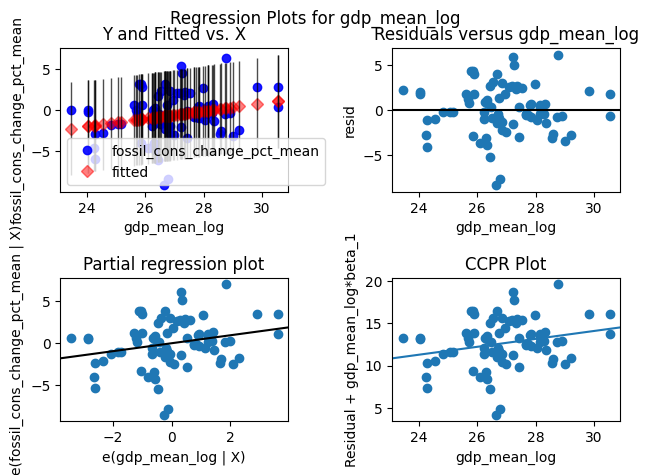

In [28]:
import statsmodels.api as sm
fig = sm.graphics.plot_regress_exog(model, 'gdp_mean_log')
plt.show()

View model results

In [29]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     fossil_cons_change_pct_mean   R-squared:                       0.058
Model:                                     OLS   Adj. R-squared:                  0.046
Method:                          Least Squares   F-statistic:                     4.757
Date:                         Mon, 03 Nov 2025   Prob (F-statistic):             0.0322
Time:                                 14:39:49   Log-Likelihood:                -190.20
No. Observations:                           79   AIC:                             384.4
Df Residuals:                               77   BIC:                             389.1
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [ ]:
#evaluate p-value for gdp_mean_log coefficient
p_value = model.pvalues['gdp_mean_log'].round(4)
print(f"P-value for GDP coefficient: {p_value}")
if p_value < 0.05:
    print("Reject null hypothesis: there is a significant relationship between GDP and fossil fuel consumption growth.")
else:
    print("Fail to reject null hypothesis: no significant relationship between GDP and fossil fuel consumption growth.")

P-value for GDP coefficient: 0.0322
Reject null hypothesis: there is a significant relationship between GDP and fossil fuel consumption growth.


**Conclusion:** based on data from the last 5 years, there is no relationship between a country's GDP and their annual growth in fossil fuel consumption (on average). 
Globally, over the last 5 years fossil fuel consumption has decreased by -0.62% on average. Countries like Vietnam and Bangladesh show some of the highest growth in fossil fuel consumption (around 5% on average over the last 5 years) while their average GDP is similar to the global average. In contrast, countries like Hong Kong and Ukraine have average GDP's below the global average, but have shown a reduction in fossil fuels of around 8-9% on average over the last 5 years.

### Renewables growth vs GDP

First, let's visualise the relationship

In [37]:
#plot renewables consumption change pct vs gdp

# Get the 'Global' datapoint
global_row = df_last5_plot[df_last5_plot['country_'] == 'Global'].iloc[0]
global_gdp = global_row['gdp_mean']
global_renew = global_row['renewables_cons_change_pct_mean']

fig = px.scatter(
    df_last5_plot,
    x='gdp_mean',
    y='renewables_cons_change_pct_mean',
    hover_name='country_',
    title='Growth in Renewables Consumption vs GDP per country (averaged over last 5 years)',
    labels={
        'gdp_mean': 'GDP (log-transformed)',
        'renewables_cons_change_pct_mean': 'Percentage growth in Renewables consumption'
    },
    log_x=True,
    trendline='ols',
    template='plotly_white',
    symbol=df_last5_plot['country_'].apply(lambda x: 'star' if x == 'Global' else 'circle'),
    color=df_last5_plot['country_'].apply(lambda x: 'red' if x == 'Global' else 'green'),
)

# Add horizontal and vertical lines for the 'Global' datapoint
fig.add_vline(x=global_gdp, line_dash="dash", line_color="red", annotation_text="Global GDP", annotation_position="top left")
fig.add_hline(y=global_renew, line_dash="dash", line_color="red", annotation_text="Global Renewables Growth", annotation_position="bottom right")

fig.update_layout(showlegend=False)  # Remove legend

fig.show()

Now let's fit the model

In [33]:
#regression analysis of fossil fuel consumption change pct vs gdp

#first we need to log-transform the gdp values
df_last5['gdp_mean_log'] = np.log(df_last5['gdp_mean'])
df_h1_test = df_last5.dropna(subset=['renewables_cons_change_pct_mean', 'gdp_mean_log'])

#perform linear regression
X = df_h1_test[['gdp_mean_log']]
y = df_h1_test['renewables_cons_change_pct_mean']
X = sm.add_constant(X)  # add constant term for intercept
model = sm.OLS(y, X).fit()

Evaluate the model fit

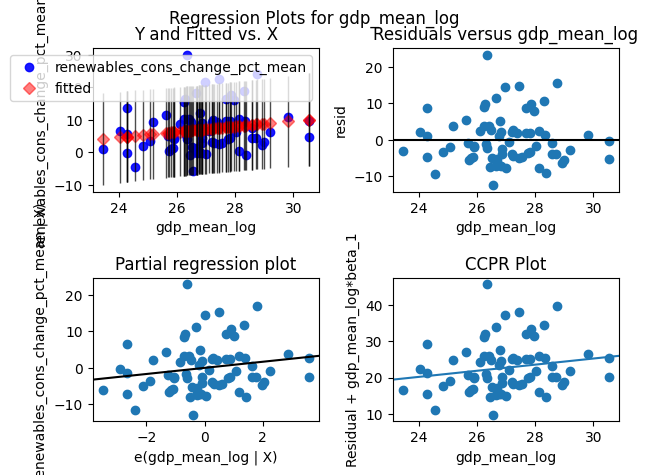

In [34]:
fig = sm.graphics.plot_regress_exog(model, 'gdp_mean_log')
plt.show()

View model output

In [35]:
print(model.summary())

#evaluate p-value for gdp_mean_log coefficient
p_value = model.pvalues['gdp_mean_log'].round(4)
print(f"P-value for GDP coefficient: {p_value}")
if p_value < 0.05:
    print("Reject null hypothesis: there is a significant relationship between GDP and fossil fuel consumption growth.")
else:
    print("Fail to reject null hypothesis: no significant relationship between GDP and fossil fuel consumption growth.")

                                   OLS Regression Results                                  
Dep. Variable:     renewables_cons_change_pct_mean   R-squared:                       0.031
Model:                                         OLS   Adj. R-squared:                  0.017
Method:                              Least Squares   F-statistic:                     2.251
Date:                             Mon, 03 Nov 2025   Prob (F-statistic):              0.138
Time:                                     14:41:24   Log-Likelihood:                -242.74
No. Observations:                               73   AIC:                             489.5
Df Residuals:                                   71   BIC:                             494.1
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]

**Conclusion:** Based on the data for the last 5 years, there is no relationship between a country's average GDP and the average annual percentage growth in renewables. Countries such as Israel, Indonesia, Netherlands and Iraq have all shown growth of over 20% on average over the last 5 years, and are both above (Indonesia, Netherlands) and below (Israel ,Iraq) the global average GDP. Latvia and Uzbekistan have shown the fastest reduction in renewables consumption over the last 5 years, on average around 5-6%.

**Further insights:** Perhaps the link between growth in fossil/renewables and GDP depends on region. To test this, we could use a multiple linear regression adding in region/continent as an interaction term with GDP.

## H2: Leaders and laggers in the green energy transition

Renewable production has increased over the last decade, accelerating the transition to green energy. The rate of this growth varies geographically, with some countries leading the way in the green energy transition and other countries falling behind.

**Test:** Identify outlier countries with above-average renewables share of production (leaders) and below-average share of renewables (laggers). 

First let's plot histograms of overall renewable production share (% of total) and per energy type, averaged over the last 5 years.

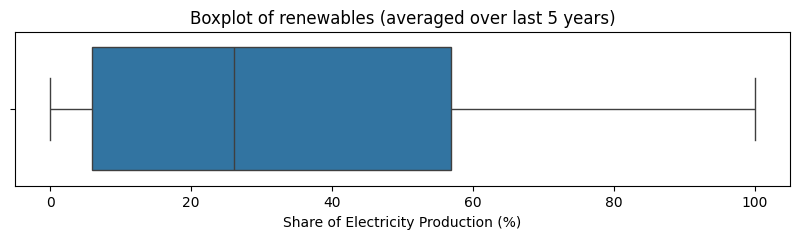

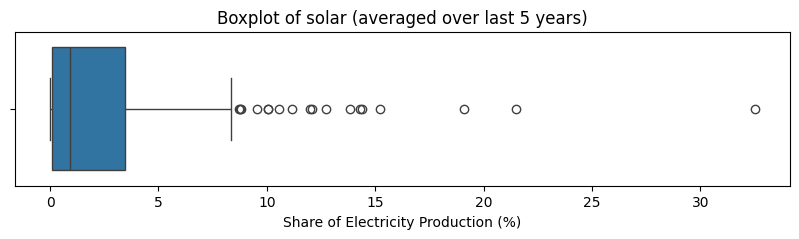

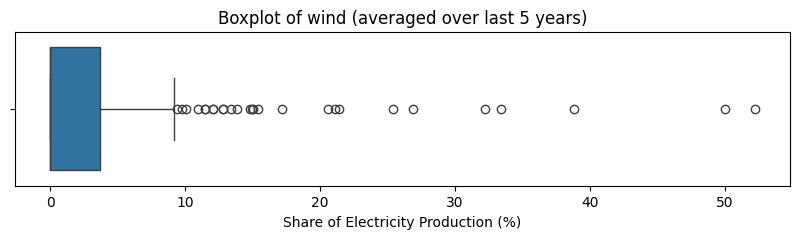

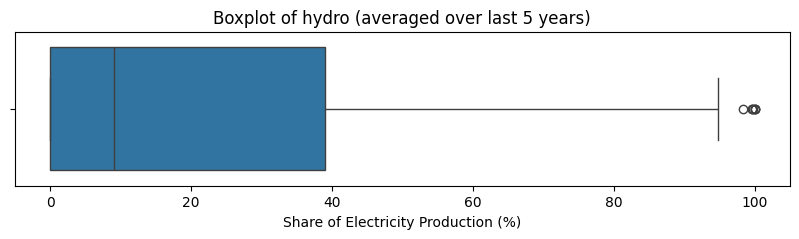

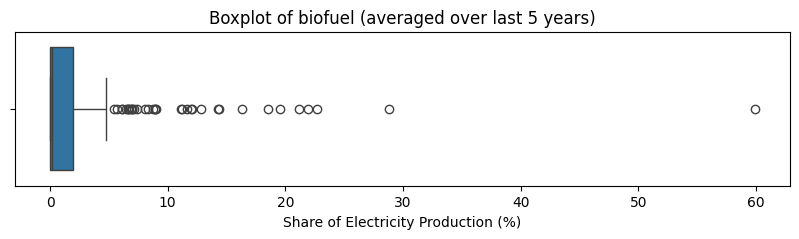

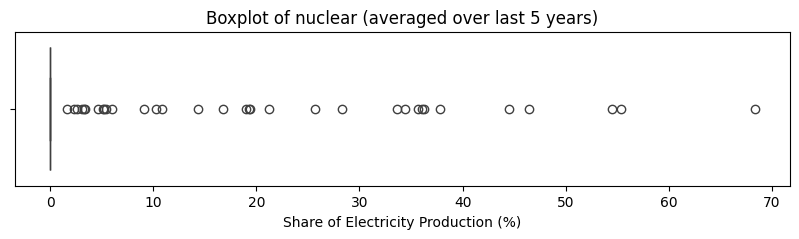

In [ ]:
#plot boxplots of renewables production share per type and overall
cols = ['renewables_share_elec_mean', 'solar_share_elec_mean', 'wind_share_elec_mean',
        'hydro_share_elec_mean', 'biofuel_share_elec_mean', 'nuclear_share_elec_mean']

for col in cols:
    plt.figure(figsize=(10, 2))
    sns.boxplot(data=df_last5, x=col)  # Changed y to x for horizontal orientation
    plt.title(f'Boxplot of {col.split("_")[0]} (averaged over last 5 years)')
    plt.xlabel('Share of Electricity Production (%)')  # Changed ylabel to xlabel
    plt.show()


Identify outliers (those outside of 1.5*upper or lower quartile) overall and per energy type. The inter-quartile range is where 50% of the data lies, and 1.5 points above or below this range is typically used to identify data in the extremes of the distribution (i.e. outliers).

In [ ]:
#function for calculating outliers based on IQR
def detect_outliers_iqr(column, threshold=1.5):
    iqr = column.quantile(0.75) - column.quantile(0.25) #IQR
    lower_bound = column.quantile(0.25) - threshold * iqr
    upper_bound = column.quantile(0.75) + threshold * iqr
    
    #Create categories based on position relative to bounds
    result = pd.Series(index=column.index, dtype='object')
    result[(column > upper_bound)] = 'leader'
    result[(column < lower_bound)] = 'lagger'
    result[((column >= lower_bound) & (column <= upper_bound)) | column.isna()] = 'normal'
    
    return result

#apply function to each renewables production share column
outliers = df_last5[['country_'] + cols].copy()
for col in cols:
    outliers[col] = detect_outliers_iqr(df_last5[col])
outliers.head()

,country_,renewables_share_elec_mean,solar_share_elec_mean,wind_share_elec_mean,hydro_share_elec_mean,biofuel_share_elec_mean,nuclear_share_elec_mean
0,Afghanistan,normal,normal,normal,normal,normal,normal
1,Albania,normal,normal,normal,leader,normal,normal
2,Algeria,normal,normal,normal,normal,normal,normal
3,American Samoa,normal,normal,normal,normal,normal,normal
4,Angola,normal,normal,normal,normal,normal,normal
...,...,...,...,...,...,...,...
211,Venezuela,normal,normal,normal,normal,normal,normal
212,Vietnam,normal,normal,normal,normal,normal,normal
213,Yemen,normal,leader,normal,normal,normal,normal
214,Zambia,normal,normal,normal,normal,normal,normal


Overall renewable energy production:

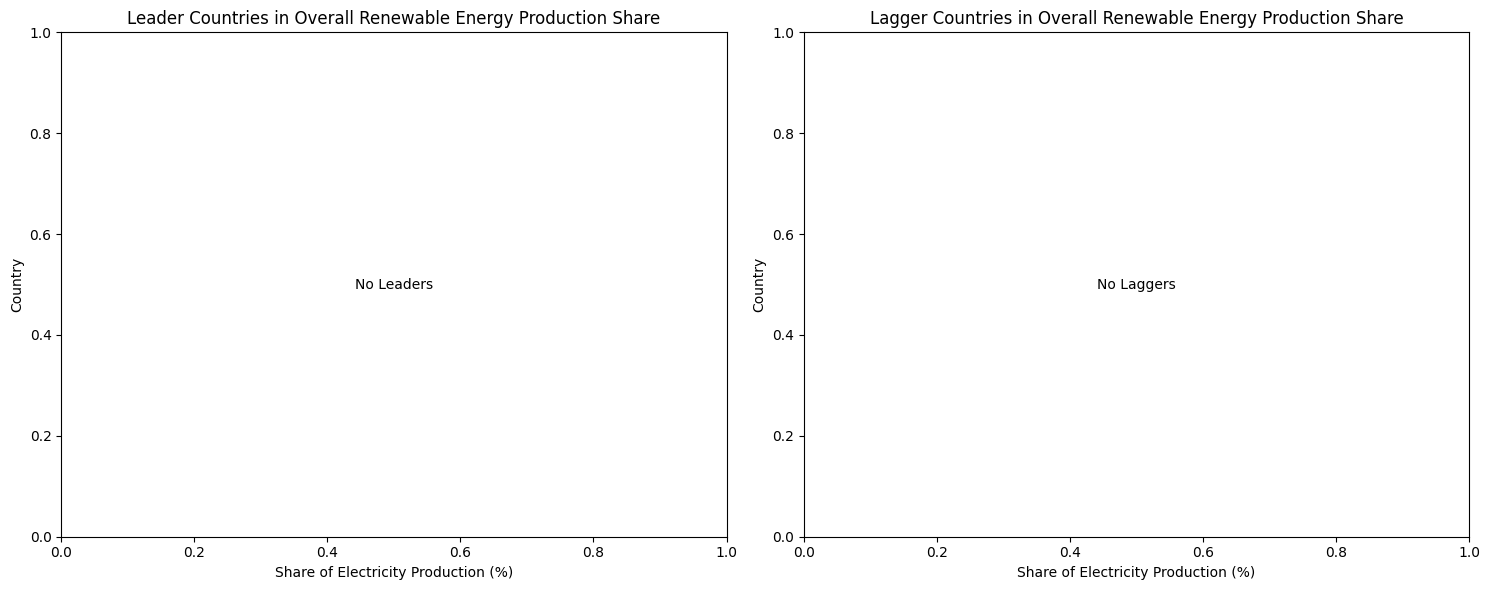

In [ ]:
#find leaders and laggers in overall renewable energy production
#filter outliers dataframe where renewables_share_elec_mean is 'leader' or 'lagger'

leaders = df_last5[outliers['renewables_share_elec_mean'] == 'leader']
laggers = df_last5[outliers['renewables_share_elec_mean'] == 'lagger']

#add horizontal barplots for leaders and laggers in overall renewable energy production share
def plot_leader_lagger_barplots(leaders, laggers, value_col, title_prefix):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    # Leaders
    if not leaders.empty:  
        sorted_leaders = leaders.sort_values(value_col, ascending=False)
        sns.barplot(data=sorted_leaders, y='country_', x=value_col, ax=axes[0], color='green')
        axes[0].set_title(f'Leader Countries in {title_prefix}')
        axes[0].set_xlabel('Share of Electricity Production (%)')
        axes[0].set_ylabel('Country')
    else:
        axes[0].text(0.5, 0.5, 'No Leaders', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
        axes[0].set_title(f'Leader Countries in {title_prefix}')
        axes[0].set_xlabel('Share of Electricity Production (%)')
        axes[0].set_ylabel('Country')
    # Laggers
    if not laggers.empty:  
        sorted_laggers = laggers.sort_values(value_col, ascending=False)
        sns.barplot(data=sorted_laggers, y='country_', x=value_col, ax=axes[1], color='red')
        axes[1].set_title(f'Lagger Countries in {title_prefix}')
        axes[1].set_xlabel('Share of Electricity Production (%)')
        axes[1].set_ylabel('Country')
    else:
        axes[1].text(0.5, 0.5, 'No Laggers', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
        axes[1].set_title(f'Lagger Countries in {title_prefix}')
        axes[1].set_xlabel('Share of Electricity Production (%)')
        axes[1].set_ylabel('Country')
    plt.tight_layout()
    plt.show()

#plot leaders and laggers in overall renewable energy production share
plot_leader_lagger_barplots(leaders, laggers, 'renewables_share_elec_mean', 'Overall Renewable Energy Production Share')

Solar energy production:

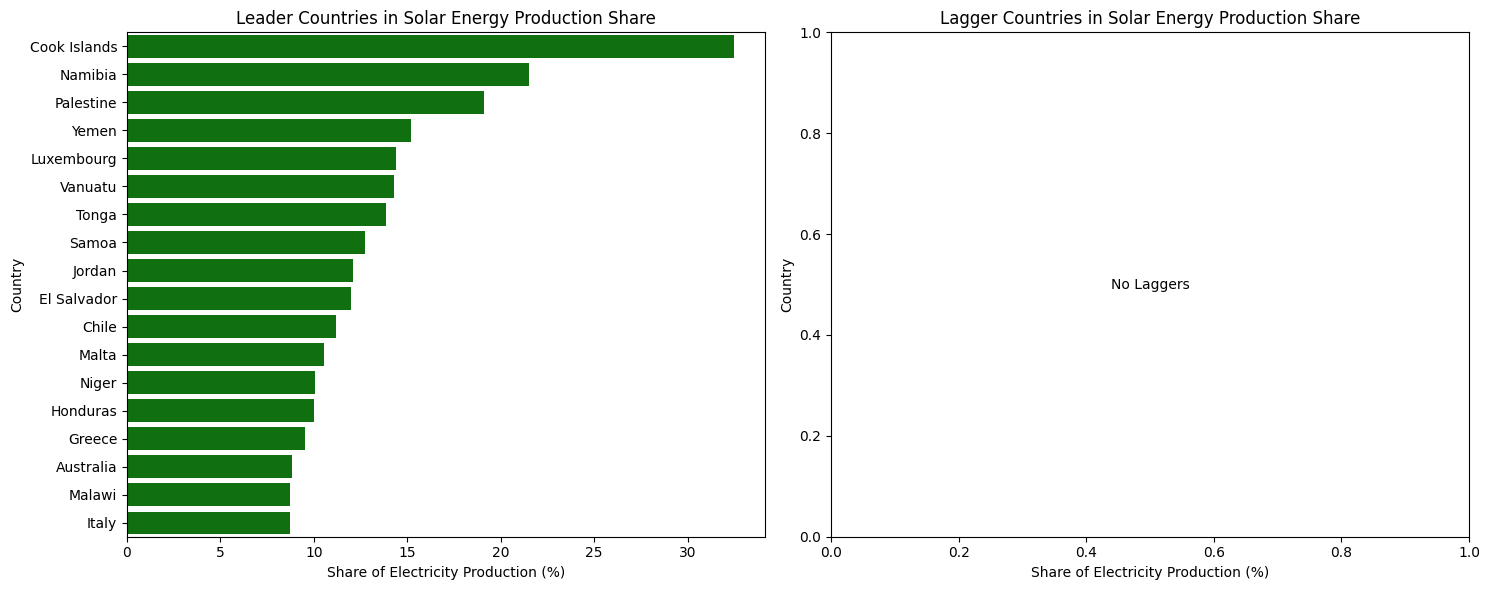

In [ ]:
leaders = df_last5[outliers['solar_share_elec_mean'] == 'leader']
laggers = df_last5[outliers['solar_share_elec_mean'] == 'lagger']

#add horizontal barplots for leaders and laggers in solar energy production share
plot_leader_lagger_barplots(leaders, laggers, 'solar_share_elec_mean', 'Solar Energy Production Share')

Wind energy production:

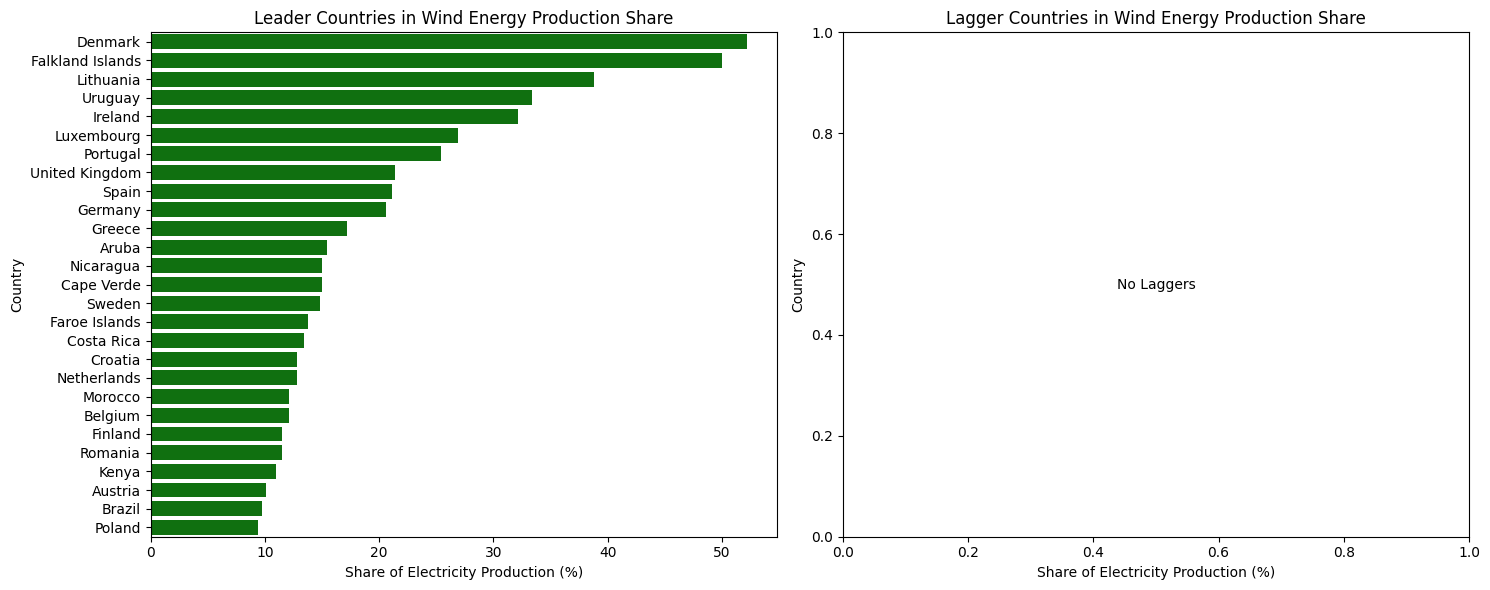

In [72]:
leaders = df_last5[outliers['wind_share_elec_mean'] == 'leader']
laggers = df_last5[outliers['wind_share_elec_mean'] == 'lagger']

#plot horizontal barplots for leaders and laggers in wind energy production share
plot_leader_lagger_barplots(leaders, laggers, 'wind_share_elec_mean', 'Wind Energy Production Share')

Hydro energy production:

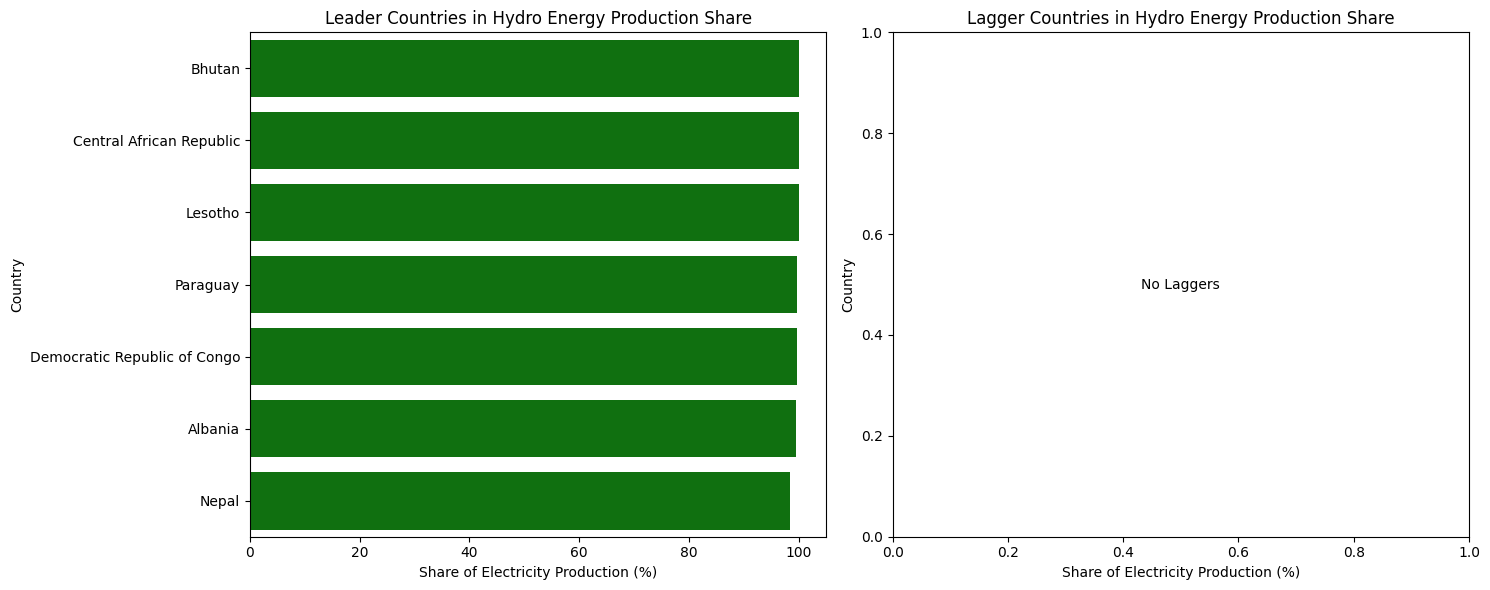

In [73]:
leaders = df_last5[outliers['hydro_share_elec_mean'] == 'leader']
laggers = df_last5[outliers['hydro_share_elec_mean'] == 'lagger']

#add horizontal barplots for leaders and laggers in overall renewable energy production share
plot_leader_lagger_barplots(leaders, laggers, 'hydro_share_elec_mean', 'Hydro Energy Production Share')

Biofuel energy production:

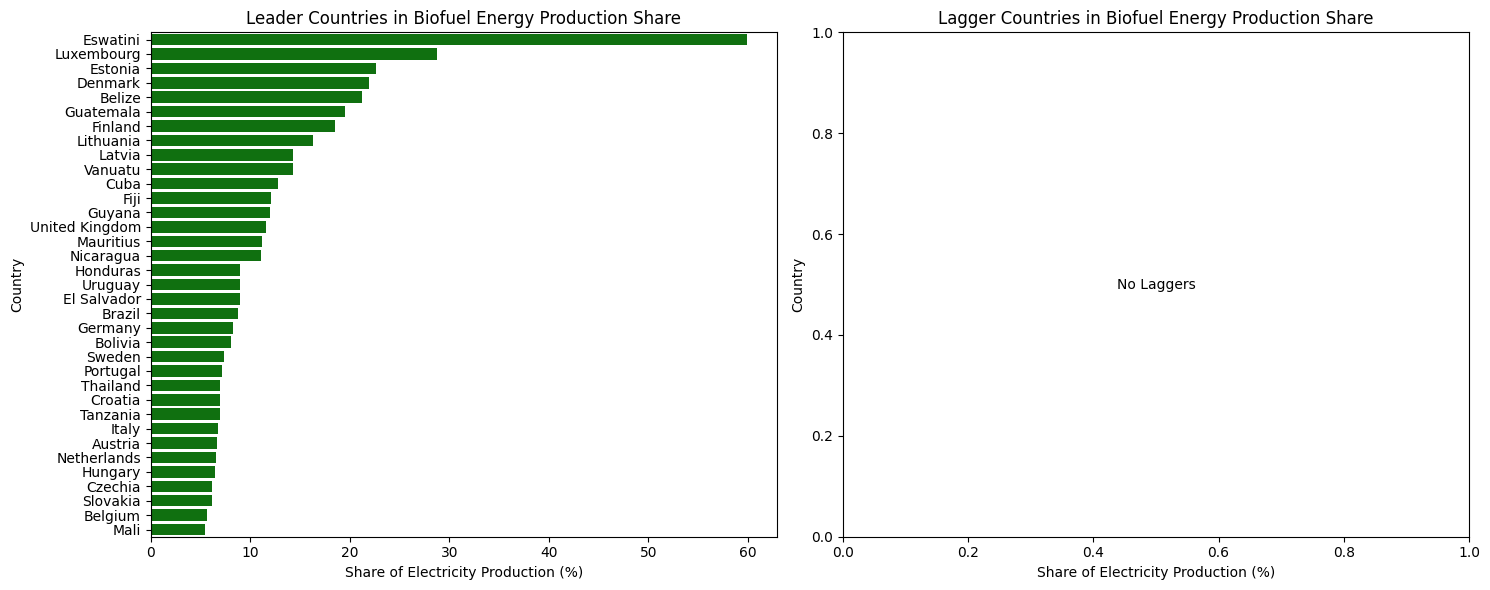

In [74]:
leaders = df_last5[outliers['biofuel_share_elec_mean'] == 'leader']
laggers = df_last5[outliers['biofuel_share_elec_mean'] == 'lagger']

#add horizontal barplots for leaders and laggers in biofuel energy production share
plot_leader_lagger_barplots(leaders, laggers, 'biofuel_share_elec_mean', 'Biofuel Energy Production Share')

Nuclear energy production:

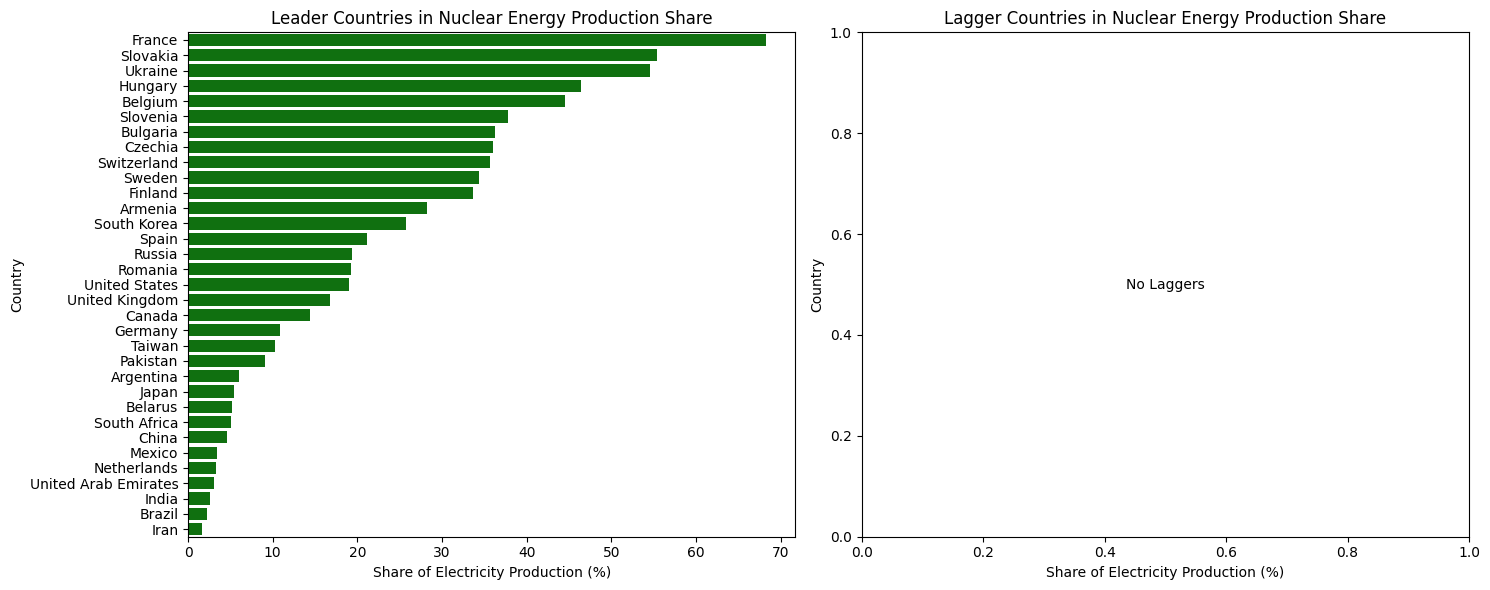

In [75]:
leaders = df_last5[outliers['nuclear_share_elec_mean'] == 'leader']
laggers = df_last5[outliers['nuclear_share_elec_mean'] == 'lagger']

#add horizontal barplots for leaders and laggers in nuclear energy production share
plot_leader_lagger_barplots(leaders, laggers, 'nuclear_share_elec_mean', 'Nuclear Energy Production Share')

**Conclusion:** In terms of average overall share of production of renewables over the last 5 years, there are no clear leaders or laggers. In addition, no countries were identified as 'laggers' in production of each type of renewable energy (likely due to the highly skewed distributions where most countries had low values to start with). However, different sets of countries were identified as leaders in the share of their energy production (averaged over the last 5 years) according to the type of renewable:

 - The Cook Islands, Namibia and Palestine are leaders in **solar** energy production, with over 20% of their energy produced via solar on average between 2018-2022. 
 - The top 3 countries producing **wind** energy were Denmark, Falkland Islands and Lithuania, with over 40% of their energy coming from wind.
 - There were 7 countries identified as leaders in **hydro** production, with around 100% of their energy coming from this source. These were; Bhutan, Central African Republic, Lesotho, Paraguay, Democratic Republic of Congo, Albania and Nepal.
 - Eswatini was a clear leader in **biofuel** production, with on average 60% of their energy from biofuel between 2018-2022, followed by Luxembourg at 30%.
 - France had the highest average % share of energy production coming from **nuclear** power between 2018-2022, followed by Slovakia and Ukraine.

## H3: Forecasting growth in renewables

Renewables have been rising over the last two decades, with growth in some renewables like solar and wind especially fast in the last 10 years. Production of renewables will continue to increase over the next ten years, accelerating the shift from fossil to green energy. 

Now let's use the full data from 1982-2022 to predict future global trends in renewables for the next 10 years (2022-2032). We'll use a recurrent neural network (RNN) model, as these are good for sequential data such as time series. Specifically, we'll use a long short-term memmory model (LSTM), which is a type of RNN that is especially good for time series as it can learn and remember information over long periods.  We'll build one model per renewable type, to show the different trajectories and forecast predictions for each. 

This tutorial was followed for time series forecasting with RNN in Pytorch: https://www.geeksforgeeks.org/data-analysis/time-series-forecasting-using-pytorch/

This page was followed for hyperparameter tuning: :https://stackoverflow.com/questions/77007252/how-to-perform-hyperparameter-tuning-of-lstm-using-gridsearchcv

Further optimisations for each model were done using Copilot.

In [29]:
#import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import math
from sklearn.preprocessing import MinMaxScaler
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from torch.optim import SGD, RMSprop, Adam
from sklearn.metrics import mean_squared_error, r2_score

Select the relevant columns and do some data cleaning (handle missing values, sum global production and format the year column).

In [8]:
#df.head()
#select columns for forecasting model
df_forecast = df[['year','country', 'biofuel_elec_per_capita', 'hydro_elec_per_capita',
                     'nuclear_elec_per_capita', 'solar_elec_per_capita', 'wind_elec_per_capita']]
#forward fill missing values per country
df_forecast = df_forecast.sort_values(['country', 'year'])
df_forecast.update(df_forecast.groupby('country').ffill())
#still some missing values e.g. no info for certain countries for biofuel and nuclear
#sum production across countries per year to get global production per year
df_forecast_global = df_forecast.groupby(['year']).sum().reset_index()
#remove country column
df_forecast_global = df_forecast_global.drop(columns=['country'])
#set year as datetime
df_forecast_global['year'] = pd.to_datetime(df_forecast_global['year'], format='%Y')
df_forecast_global.head()


,year,biofuel_elec_per_capita,hydro_elec_per_capita,nuclear_elec_per_capita,solar_elec_per_capita,wind_elec_per_capita
0,1982-01-01,0.0,87723.111,23369.680,0.000,3.609
1,1983-01-01,0.0,93020.198,26979.516,0.013,5.659
2,1984-01-01,0.0,94185.041,32175.857,0.041,7.108
3,1985-01-01,0.0,97981.325,41960.908,0.064,10.819
4,1986-01-01,0.0,96612.576,45896.587,0.078,25.385


Let's make a quick plot to visualise production per energy type 1982-2022

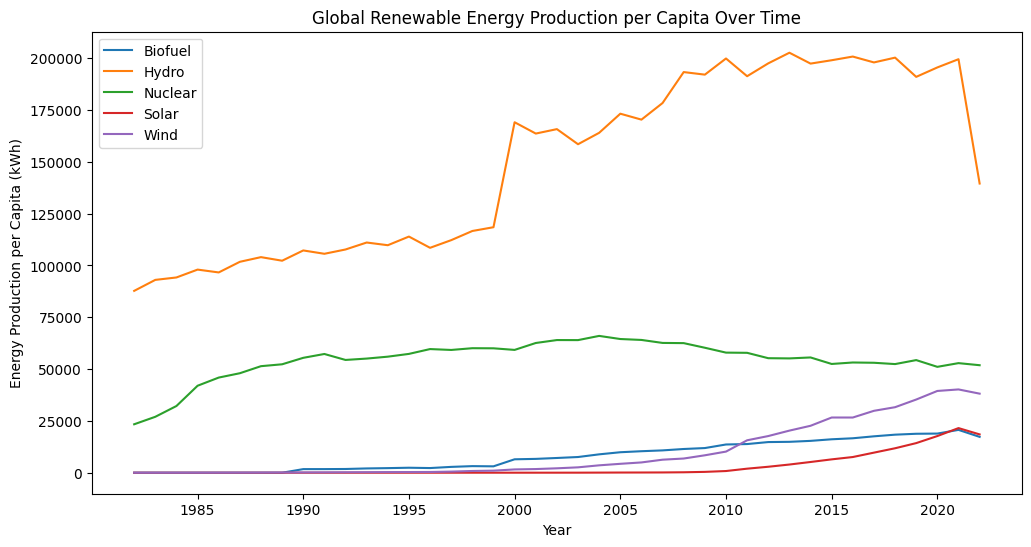

In [9]:
#plot time series of global renewable energy production per capita
plt.figure(figsize=(12, 6))
plt.plot(df_forecast_global['year'], df_forecast_global['biofuel_elec_per_capita'], label='Biofuel')
plt.plot(df_forecast_global['year'], df_forecast_global['hydro_elec_per_capita'], label='Hydro')
plt.plot(df_forecast_global['year'], df_forecast_global['nuclear_elec_per_capita'], label='Nuclear')
plt.plot(df_forecast_global['year'], df_forecast_global['solar_elec_per_capita'], label='Solar')
plt.plot(df_forecast_global['year'], df_forecast_global['wind_elec_per_capita'], label='Wind')
plt.title('Global Renewable Energy Production per Capita Over Time')
plt.xlabel('Year')
plt.ylabel('Energy Production per Capita (kWh)')
plt.legend()
plt.show()

In [ ]:
#set year as index
df_forecast_global = df_forecast_global.set_index('year')

Model set-up:

Before we begin, we will set up the model classes and functions to be used for each renewable model.

In [ ]:
# Create sequences and labels for training data
def create_sequences(scaled_data, sequence_length):
    """
    Create sliding-window sequences and next-step labels and convert to PyTorch tensors.
    scaled_data: numpy array or array-like of shape (n_samples, n_features) or (n_samples,)
    sequence_length: number of time steps to include in each input sequence
    Returns: X (torch.Tensor: num_sequences, sequence_length, n_features), 
             y (torch.Tensor: num_sequences, n_features)
    """
    arr = np.asarray(scaled_data)
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    X, y = [], []
    for i in range(len(arr) - sequence_length):
        X.append(arr[i:i + sequence_length])
        y.append(arr[i + sequence_length])
    X = np.array(X)
    y = np.array(y)
    # Convert to torch tensors (float32)
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    return X_t, y_t

In [ ]:
#set up the code for hyperparameter optimisation
class LSTMModel_1(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3, output_size=1, dropout=0.2):
        super(LSTMModel_1, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Get the output from the last time step
        out = self.linear(out[:, -1, :])
        return out

    # Required for skorch compatibility
    def get_params(self, deep=True):
        return {
            'input_size': 1,
            'hidden_size': self.hidden_size,
            'num_layers': self.num_layers,
            'output_size': 1
        }
    
# Create the model with skorch, specifying optimizer explicitly
model_1 = NeuralNetRegressor(
    LSTMModel_1,
    criterion=nn.MSELoss(reduction='mean'),
    optimizer=Adam,  # Pass optimizer class, not string
    verbose=False
)

# Define grid search parameters - modify optimizer param
param_grid = {
    'batch_size': [10, 20, 40, 60, 80, 100],
    'max_epochs': [10, 50, 100],
    'optimizer__lr': [0.001, 0.01, 0.1],  # Learning rates for optimizer
    # Add other optimizer-specific parameters if needed
    # 'optimizer__weight_decay': [0.0001, 0.001],
    # 'optimizer__momentum': [0.9], # for SGD
}

# Run grid search
grid = GridSearchCV(estimator=model_1, 
                   param_grid=param_grid, 
                   n_jobs=-1, 
                   cv=3, 
                   scoring='r2',
                   error_score='raise')  # Added to get more detailed error messages

In [ ]:
#Set up the final model class to be used for prediction
class LSTMModel_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel_2, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')#uses gpu if available, otherwise cpu
print(device)

#use these as a starting point (these may change as we optimise each model)
input_size = 1
num_layers = 3  
hidden_size = 128  
output_size = 1
dropout = 0.2  
weight_decay = 1e-6
loss_fn = nn.MSELoss(reduction='mean')

cpu


For each energy type, we will need to do the following tasks to prep the data:
- select relevant columns and handle missing values
- split into train and test sets
- scale variables
- create sequences for the model to use

#### Biofuel

In [196]:

#split data into test and train sets
training_data_len = 25 #(first 25 years)

# Splitting the dataset
train_data = df_forecast_global[:training_data_len].iloc[:, :1]#select the column here (biofuel is 1st)
test_data = df_forecast_global[training_data_len:].iloc[:, :1]
print(train_data.shape, test_data.shape)
train_data

(25, 1) (16, 1)


,biofuel_elec_per_capita
year,
1982-01-01,0.000
1983-01-01,0.000
1984-01-01,0.000
1985-01-01,0.000
1986-01-01,0.000
1987-01-01,0.000
1988-01-01,0.000
1989-01-01,0.000
1990-01-01,1739.151


In [197]:
# Selecting biofuel production for test and train sets
dataset_train = train_data.biofuel_elec_per_capita.values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1, 1))
print(dataset_train.shape)

dataset_test = test_data.biofuel_elec_per_capita.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1, 1))
print(dataset_test.shape)

(25, 1)
(16, 1)


In [198]:
# Scaling dataset between 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

scaled_test = scaler.transform(dataset_test)
print(scaled_test[:5])

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[1.03839836]
 [1.10325512]
 [1.14685133]
 [1.3128841 ]
 [1.33318713]]


Now we need to create sequences for the model, where each sequence contains a specified number of time steps. These are the 'windows' that the model will use for prediction. 

In [284]:
# create train sequences (returns PyTorch tensors)
sequence_length=2
X_train, y_train = create_sequences(scaled_train, sequence_length)
print(X_train.shape, y_train.shape)
X_test, y_test = create_sequences(scaled_test, sequence_length)
print(X_test.shape, y_test.shape)

torch.Size([23, 2, 1]) torch.Size([23, 1])
torch.Size([14, 2, 1]) torch.Size([14, 1])


Tune hyperparameters

In [285]:
#fit it to the data
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best accuracy of: %f using %s" % (grid_result.best_score_, 
                                         grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best accuracy of: -1.409267 using {'batch_size': 20, 'max_epochs': 100, 'optimizer__lr': 0.001}
-71.287155 (40.886005) with: {'batch_size': 10, 'max_epochs': 10, 'optimizer__lr': 0.001}
-24.537864 (22.431734) with: {'batch_size': 10, 'max_epochs': 10, 'optimizer__lr': 0.01}
-53.462518 (42.912067) with: {'batch_size': 10, 'max_epochs': 10, 'optimizer__lr': 0.1}
-15.033879 (11.990852) with: {'batch_size': 10, 'max_epochs': 50, 'optimizer__lr': 0.001}
-6.076438 (5.375718) with: {'batch_size': 10, 'max_epochs': 50, 'optimizer__lr': 0.01}
-68.550568 (37.457585) with: {'batch_size': 10, 'max_epochs': 50, 'optimizer__lr': 0.1}
-2.920821 (2.581014) with: {'batch_size': 10, 'max_epochs': 100, 'optimizer__lr': 0.001}
-2.603291 (1.429899) with: {'batch_size': 10, 'max_epochs': 100, 'optimizer__lr': 0.01}
-68.562647 (37.833927) with: {'batch_size': 10, 'max_epochs': 100, 'optimizer__lr': 0.1}
-11.016701 (5.375814) with: {'batch_size': 20, 'max_epochs': 10, 'optimizer__lr': 0.001}
-48.010143 (21.30

Define and train the model using the best parameters identified

In [ ]:

#specify hyperparameters (Change based on gridsearch)
batch_size = 20
num_epochs = 100 
lr = 0.001
#further tuning
num_layers = 1  
hidden_size = 64
dropout = 0.1
weight_decay = 1e-6
loss_fn = nn.MSELoss(reduction='mean')
# Robust loss handles recent spikes better than MSE
#loss_fn = nn.SmoothL1Loss(beta=0.5)


#using model class specified in earlier section
model_2 = LSTMModel_2(input_size, hidden_size, num_layers, output_size, dropout).to(device)
optimizer = optim.Adam(model_2.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-5)


# Time-based validation from the tail of X_train (no peeking into test)
val_frac = 0.2 #fraction to use
val_n = max(1, int(len(X_train) * val_frac))
train_n = len(X_train) - val_n
X_tr, y_tr = X_train[:train_n], y_train[:train_n]#split from test set
X_val, y_val = X_train[train_n:], y_train[train_n:]

train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

train_hist = []#store training and validation history here
val_hist = []

# Early stopping (helps prevent overfitting)
best_val = float('inf')
best_state = None
patience = 20
epochs_no_improve = 0

#run the model in a loop (epochs) and store results, stopping when model fit stops improving
for epoch in range(num_epochs):
    model_2.train()
    total_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        preds = model_2(batch_X)
        loss = loss_fn(preds, batch_y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_2.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_train = total_loss / max(1, len(train_loader))
    train_hist.append(avg_train)

    model_2.eval()
    total_val = 0.0
    with torch.no_grad():
        for bx, by in val_loader:
            bx, by = bx.to(device), by.to(device)
            pv = model_2(bx)
            total_val += loss_fn(pv, by).item()
    avg_val = total_val / max(1, len(val_loader))
    val_hist.append(avg_val)

    scheduler.step(avg_val)

    if avg_val < best_val - 1e-6:
        best_val = avg_val
        best_state = {k: v.cpu().clone() for k, v in model_2.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}/{num_epochs} - train:{avg_train:.6f} val:{avg_val:.6f} lr:{optimizer.param_groups[0]["lr"]:.2e}')

    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}. Best val loss: {best_val:.6f}')
        break

# Load best weights
if best_state is not None:
    model_2.load_state_dict(best_state)

c:\Users\User\OneDrive\Documents\Code Institute Data Analytics and AI\Capstone project - renewables\global_renewable_energy_analysis\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch 20/100 - train:0.042454 val:0.370479 lr:1.00e-03
Epoch 40/100 - train:0.037597 val:0.346269 lr:1.00e-03
Epoch 60/100 - train:0.030673 val:0.247259 lr:1.00e-03
Epoch 80/100 - train:0.019928 val:0.118646 lr:1.00e-03
Epoch 100/100 - train:0.008965 val:0.007527 lr:1.00e-03


Compare training and validation losses. The loss represents the difference between predicted output and actual target value. During training, the model tries to minimise this loss by adjusting their weights. These are used to monitor the model's performance and generalization ability.

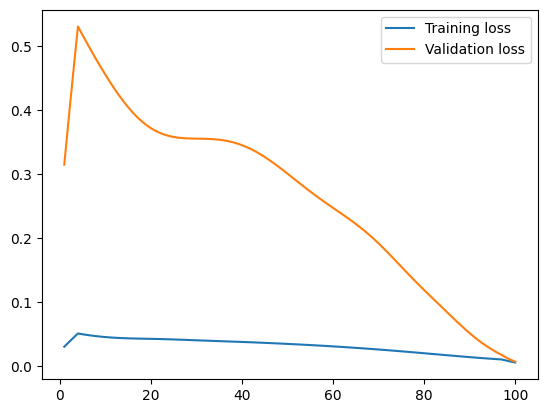

In [297]:
x = np.arange(1, len(train_hist)+1)

# optional smoothing for nicer curves
def smooth(arr, k=5):
    import numpy as np
    if k <= 1 or len(arr) < k: return arr
    w = np.ones(k)/k
    return np.convolve(arr, w, mode='same')

plt.plot(x, smooth(train_hist, k=7), label="Training loss")
plt.plot(x, smooth(val_hist, k=7), label="Validation loss")
plt.legend()
plt.show()

Evaluate model performance using root mean squared error (RMSE) and R-squared score. These help to quantify the model's accuracy and explanatory power. RMSE measures the average magnitude of the erros between predicted and actual values. Rsquared measures the amount of variance explained by the model. We want to minimise RMSE and maximise R-squared.

In [298]:
# Evaluate the model and calculate RMSE and R² score
model_2.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)  # Add batch dimension
        test_predictions.append(model_2(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

RMSE: 0.0907
R² Score: 0.8380


Look at predicted vs actual values

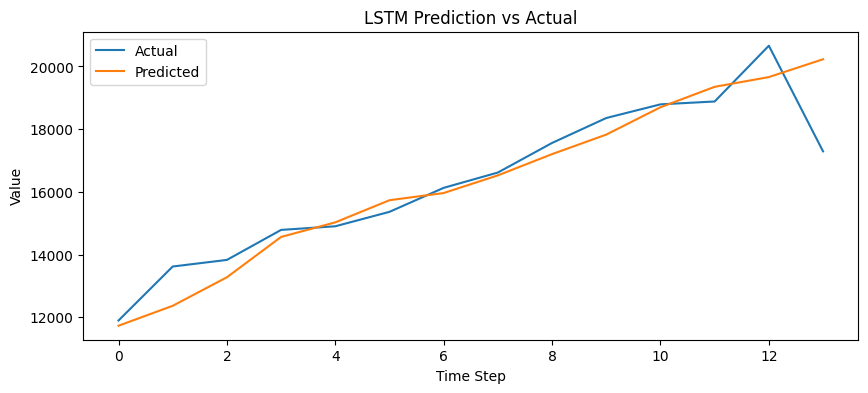

In [ ]:
model_2.eval()  
with torch.no_grad():  
  predictions = model_2(X_test).squeeze().numpy() # Predict on test set  

# Inverse transform to original scale  
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))  
predictions_inv = scaler.inverse_transform(predictions.reshape(-1, 1))  

# Plot actual vs predicted  
plt.figure(figsize=(10, 4))  
plt.plot(y_test_inv, label='Actual')  
plt.plot(predictions_inv, label='Predicted')  
plt.title("LSTM Prediction vs Actual")  
plt.xlabel("Time Step")  
plt.ylabel("Biofuel production per capita (kWh)")  
plt.legend()  
plt.show() 

Forecast future values

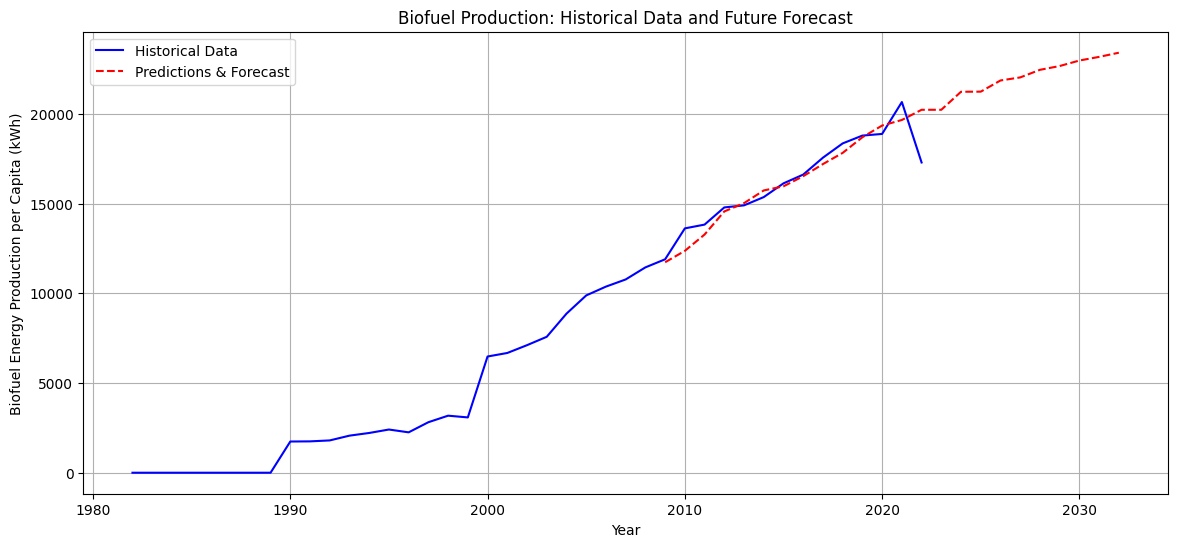

In [ ]:
num_forecast_steps = 10 #number of years to forecast 
sequence_to_plot = X_test.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]

# Generate forecast values
forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model_2(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

# Get predictions for test period (2014-2022)
model_2.eval()
with torch.no_grad():
    test_predictions = model_2(X_test).cpu().numpy()
    test_predictions = scaler.inverse_transform(test_predictions)

# Create date range for full prediction period (2014-2032)
last_historical_date = test_data.index[-1]
future_dates = pd.date_range(start=last_historical_date + pd.DateOffset(years=1),
                           periods=num_forecast_steps,
                           freq='YS')

# Align prediction dates with actual predictions length
prediction_dates = test_data.index[-(len(test_predictions)):].union(future_dates)

# Combine test predictions and forecast
all_predictions = np.concatenate([test_predictions.flatten(), 
                                scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()])

plt.figure(figsize=(14, 6))

# Plot complete historical data (1982-2022)
plt.plot(df_forecast_global.index, df_forecast_global['biofuel_elec_per_capita'],
         label='Historical Data', color='blue')

# Plot predictions (2014-2032) 
plt.plot(prediction_dates, all_predictions,
         label='Predictions & Forecast', color='red', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Biofuel Energy Production per Capita (kWh)')
plt.title('Biofuel Production: Historical Data and Future Forecast')
plt.legend()
plt.grid(True)
plt.show()


Save model

In [301]:
# Save the model state dictionary and hyperparameters
model_save_path = './models/lstm_biofuel_forecast.pth'
model_config = {
    'state_dict': model_2.state_dict(),
    'hyperparameters': {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'output_size': output_size,
        'dropout': dropout
    },
    'scaler': scaler
}

# Save the model
torch.save(model_config, model_save_path)
print(f"Model saved to {model_save_path}")

# To load the model later:
# def load_model(model_path):
#     """Load a saved LSTM model and its configuration"""
#     # Load the saved model configuration
#     model_config = torch.load(model_path)
    
    # # Create a new model instance with saved hyperparameters
    # model = LSTMModel_2(
    #     input_size=model_config['hyperparameters']['input_size'],
    #     hidden_size=model_config['hyperparameters']['hidden_size'],
    #     num_layers=model_config['hyperparameters']['num_layers'],
    #     output_size=model_config['hyperparameters']['output_size'],
    #     dropout=model_config['hyperparameters']['dropout']
    # )
    
    # # Load the saved state dictionary
    # model.load_state_dict(model_config['state_dict'])
    
    # # Load the scaler
    # scaler = model_config['scaler']
    
    # return model, scaler

# Example of loading the model:
# loaded_model, loaded_scaler = load_model('./models/lstm_hydro_forecast.pth')

Model saved to ./models/lstm_biofuel_forecast.pth


The model closely predicts biofuel production in the test data, with actual production increasing between 2008-2022. However, there is a sharp decrease in global biofuel production in the last two years, and the model evens out this sudden drop. Global biofuel production is predicted to increase over the next decade to just under 25,000 kWh by 2032.

#### Hydro

Let's repeat the process with Hydro. First, we need to prep the data for the model.

In [ ]:
#split data into test and train sets
training_data_len = 25 #(first 25 years)

# Splitting the dataset
train_data = df_forecast_global[:training_data_len].iloc[:, 1:2]#select the column here 
test_data = df_forecast_global[training_data_len:].iloc[:, 1:2]
print(train_data.shape, test_data.shape)

# Selecting hydro production for test and train sets
dataset_train = train_data.hydro_elec_per_capita.values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1, 1))
print(dataset_train.shape)

dataset_test = test_data.hydro_elec_per_capita.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1, 1))
print(dataset_test.shape)

# Scaling dataset between 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

scaled_test = scaler.transform(dataset_test)
print(scaled_test[:5])

# create train sequences (using function defined in earlier section)
sequence_length=5
X_train, y_train = create_sequences(scaled_train, sequence_length)
print(X_train.shape, y_train.shape)
X_test, y_test = create_sequences(scaled_test, sequence_length)
print(X_test.shape, y_test.shape)

(25, 1) (16, 1)
(25, 1)
(16, 1)
[[0.        ]
 [0.06198406]
 [0.07561451]
 [0.12003687]
 [0.10402041]]
[[1.06030282]
 [1.23493637]
 [1.22050731]
 [1.31166729]
 [1.21163396]]
torch.Size([20, 5, 1]) torch.Size([20, 1])
torch.Size([11, 5, 1]) torch.Size([11, 1])


Now let's optimise hyperparameters

In [ ]:
#fit the LSTM model to the data (using the class and grid search params defined in earlier section)

#fit it to the data
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best accuracy of: %f using %s" % (grid_result.best_score_, 
                                         grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Now we can fit the model using the best hyperparameters identified

In [ ]:
#specify hyperparameters (Change based on gridsearch)
batch_size = 10
num_epochs = 500 
lr = 0.002
#further tuning
num_layers = 1
hidden_size = 64
dropout = 0.0
weight_decay = 1e-6
#loss_fn = nn.MSELoss(reduction='mean')
# Robust loss handles recent spikes better than MSE
loss_fn = nn.SmoothL1Loss(beta=0.5)

#using model class specified in earlier section
model_2 = LSTMModel_2(input_size, hidden_size, num_layers, output_size, dropout).to(device)
optimizer = optim.Adam(model_2.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=15, min_lr=1e-6)

# Time-based validation from the tail of X_train (no peeking into test)
val_frac = 0.2
val_n = max(1, int(len(X_train) * val_frac))
train_n = len(X_train) - val_n
X_tr, y_tr = X_train[:train_n], y_train[:train_n]
X_val, y_val = X_train[train_n:], y_train[train_n:]

train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

train_hist = []
val_hist = []

# Early stopping
best_val = float('inf')
best_state = None
patience = 20
epochs_no_improve = 0

for epoch in range(num_epochs):
    model_2.train()
    total_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        preds = model_2(batch_X)
        loss = loss_fn(preds, batch_y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_2.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_train = total_loss / max(1, len(train_loader))
    train_hist.append(avg_train)

    model_2.eval()
    total_val = 0.0
    with torch.no_grad():
        for bx, by in val_loader:
            bx, by = bx.to(device), by.to(device)
            pv = model_2(bx)
            total_val += loss_fn(pv, by).item()
    avg_val = total_val / max(1, len(val_loader))
    val_hist.append(avg_val)

    scheduler.step(avg_val)

    if avg_val < best_val - 1e-6:
        best_val = avg_val
        best_state = {k: v.cpu().clone() for k, v in model_2.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}/{num_epochs} - train:{avg_train:.6f} val:{avg_val:.6f} lr:{optimizer.param_groups[0]["lr"]:.2e}')

    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}. Best val loss: {best_val:.6f}')
        break

# Load best weights
if best_state is not None:
    model_2.load_state_dict(best_state)

Epoch 20/500 - train:0.049182 val:0.096185 lr:2.00e-03
Epoch 40/500 - train:0.041069 val:0.006106 lr:1.40e-03
Epoch 60/500 - train:0.019345 val:0.345621 lr:9.80e-04
Early stopping at epoch 63. Best val loss: 0.000355


Compare training and validation losses

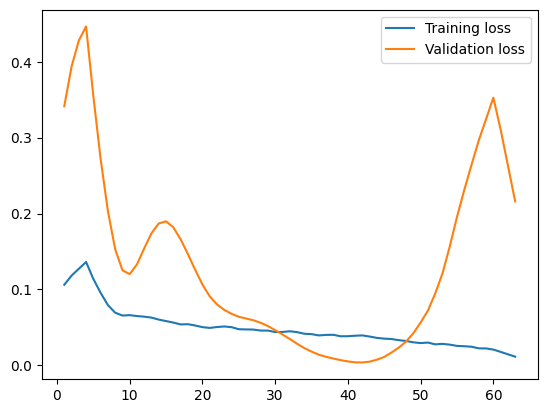

In [482]:
x = np.arange(1, len(train_hist)+1)

# optional smoothing for nicer curves
def smooth(arr, k=5):
    import numpy as np
    if k <= 1 or len(arr) < k: return arr
    w = np.ones(k)/k
    return np.convolve(arr, w, mode='same')

plt.plot(x, smooth(train_hist, k=7), label="Training loss")
plt.plot(x, smooth(val_hist, k=7), label="Validation loss")
plt.legend()
plt.show()

Evaluate model performance

In [ ]:
# Evaluate the model and calculate RMSE and R² score 
model_2.eval()
with torch.no_grad():
    val_predictions = []
    for batch_X_val in X_val:
        batch_X_val = batch_X_val.to(device).unsqueeze(0)
        val_predictions.append(model_2(batch_X_val).detach().cpu().numpy().flatten()[0])

val_predictions = np.array(val_predictions)
rmse = np.sqrt(mean_squared_error(y_val.detach().cpu().numpy(), val_predictions))
r2 = r2_score(y_val.detach().cpu().numpy(), val_predictions)
print(f'Validation RMSE: {rmse:.4f}')
print(f'Validation R² Score: {r2:.4f}')

Validation RMSE: 0.0188
Validation R² Score: 0.9204
Test RMSE: 0.2638
Test R² Score: -0.7373


Plot actual vs predicted values

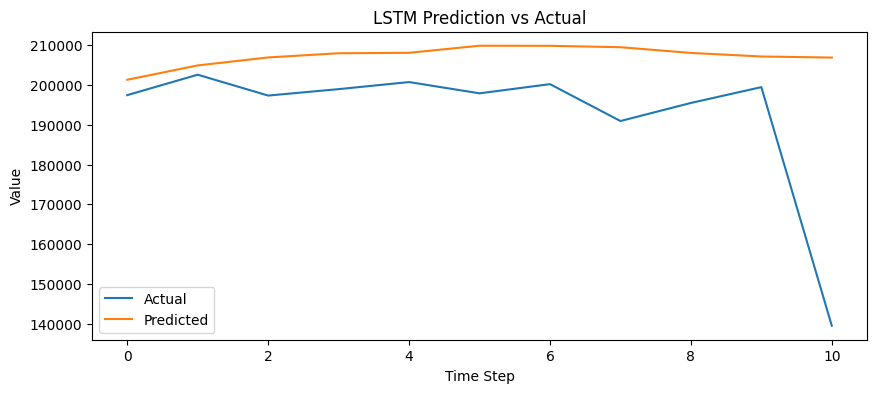

In [484]:
model_2.eval()  
with torch.no_grad():  
  predictions = model_2(X_test).squeeze().numpy() # Predict on test set  

# Inverse transform to original scale  
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))  
predictions_inv = scaler.inverse_transform(predictions.reshape(-1, 1))  

# Plot actual vs predicted  
plt.figure(figsize=(10, 4))  
plt.plot(y_test_inv, label='Actual')  
plt.plot(predictions_inv, label='Predicted')  
plt.title("LSTM Prediction vs Actual")  
plt.xlabel("Time Step")  
plt.ylabel("Value")  
plt.legend()  
plt.show() 

Forecast predictions

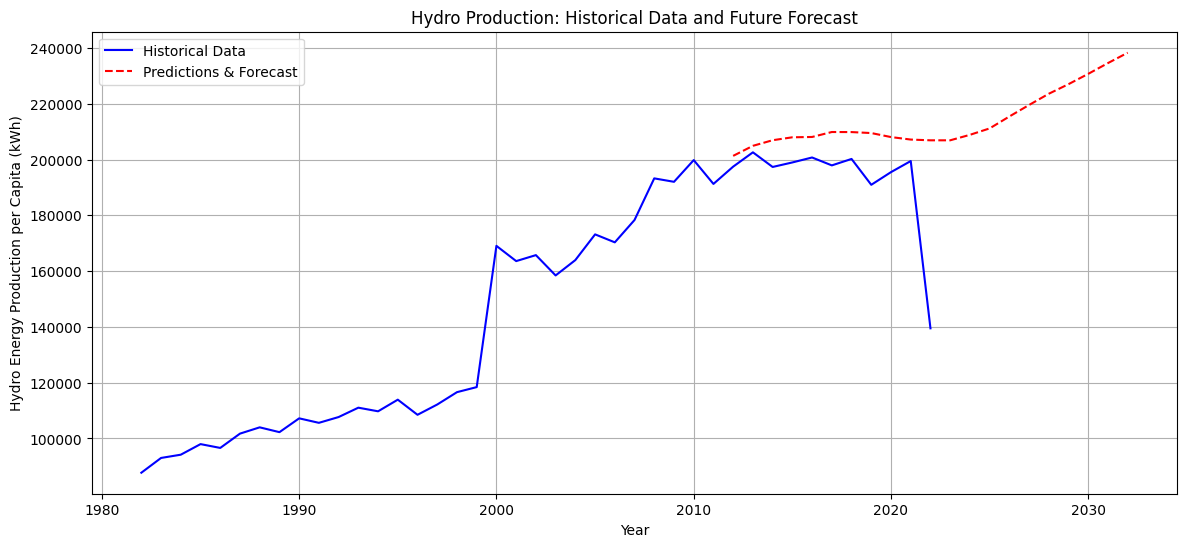

In [487]:
num_forecast_steps = 10
sequence_to_plot = X_test.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]

# Generate forecast values
forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model_2(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

# Get predictions for test period (2014-2022)
model_2.eval()
with torch.no_grad():
    test_predictions = model_2(X_test).cpu().numpy()
    test_predictions = scaler.inverse_transform(test_predictions)

# Create date range for full prediction period (2014-2032)
last_historical_date = test_data.index[-1]
future_dates = pd.date_range(start=last_historical_date + pd.DateOffset(years=1),
                           periods=num_forecast_steps,
                           freq='YS')

# Align prediction dates with actual predictions length
prediction_dates = test_data.index[-(len(test_predictions)):].union(future_dates)

# Combine test predictions and forecast
all_predictions = np.concatenate([test_predictions.flatten(), 
                                scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()])

plt.figure(figsize=(14, 6))

# Plot complete historical data (1982-2022)
plt.plot(df_forecast_global.index, df_forecast_global['hydro_elec_per_capita'],
         label='Historical Data', color='blue')

# Plot predictions (2014-2032) 
plt.plot(prediction_dates, all_predictions,
         label='Predictions & Forecast', color='red', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Hydro Energy Production per Capita (kWh)')
plt.title('Hydro Production: Historical Data and Future Forecast')
plt.legend()
plt.grid(True)
plt.show()

Save the model

In [488]:
# Save the model state dictionary and hyperparameters
model_save_path = './models/lstm_hydro_forecast.pth'
model_config = {
    'state_dict': model_2.state_dict(),
    'hyperparameters': {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'output_size': output_size,
        'dropout': dropout
    },
    'scaler': scaler
}

# Save the model
torch.save(model_config, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./models/lstm_hydro_forecast.pth


Predicted values of hydro production for 2008-2021 are slightly higher than actual values, showing the model overestimates hydro production. However, from 2021-2022 there is a large sudden drop in hydro production, almost halving in the space of a year. The model forecast does not pick up this sudden drop, but rather continues the steady increase in production seen in previous years.

#### Nuclear

Now let's repeat the process for nuclear power

In [653]:
#split data into test and train sets
training_data_len = 25 #(first 25 years)

# Splitting the dataset
train_data = df_forecast_global[:training_data_len].iloc[:, 2:3]#select the column here 
test_data = df_forecast_global[training_data_len:].iloc[:, 2:3]
print(train_data.shape, test_data.shape)

# Selecting nuclear production for test and train sets
dataset_train = train_data.nuclear_elec_per_capita.values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1, 1))
print(dataset_train.shape)

dataset_test = test_data.nuclear_elec_per_capita.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1, 1))
print(dataset_test.shape)

# Scaling dataset between 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

scaled_test = scaler.transform(dataset_test)
print(scaled_test[:5])

# create train sequences (using function defined in earlier section)
sequence_length = 2
X_train, y_train = create_sequences(scaled_train, sequence_length)
X_test, y_test = create_sequences(scaled_test, sequence_length)
print("X_train, y_train, X_test, y_test shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(25, 1) (16, 1)
(25, 1)
(16, 1)
[[0.        ]
 [0.08468754]
 [0.20659482]
 [0.43615424]
 [0.52848612]]
[[0.92060509]
 [0.91833409]
 [0.8660062 ]
 [0.81091924]
 [0.80864836]]
X_train, y_train, X_test, y_test shapes: torch.Size([23, 2, 1]) torch.Size([23, 1]) torch.Size([14, 2, 1]) torch.Size([14, 1])


Optimise hyperparameters

In [167]:
#fit it to the data
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best accuracy of: %f using %s" % (grid_result.best_score_, 
                                         grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best accuracy of: -1.243093 using {'batch_size': 10, 'max_epochs': 100, 'optimizer__lr': 0.01}
-96.417309 (82.451487) with: {'batch_size': 10, 'max_epochs': 10, 'optimizer__lr': 0.001}
-7.005414 (4.812483) with: {'batch_size': 10, 'max_epochs': 10, 'optimizer__lr': 0.01}
-18.974588 (19.049341) with: {'batch_size': 10, 'max_epochs': 10, 'optimizer__lr': 0.1}
-3.540162 (0.824498) with: {'batch_size': 10, 'max_epochs': 50, 'optimizer__lr': 0.001}
-3.592012 (1.934412) with: {'batch_size': 10, 'max_epochs': 50, 'optimizer__lr': 0.01}
-7.158192 (1.906775) with: {'batch_size': 10, 'max_epochs': 50, 'optimizer__lr': 0.1}
-3.202139 (1.268590) with: {'batch_size': 10, 'max_epochs': 100, 'optimizer__lr': 0.001}
-1.243093 (1.263105) with: {'batch_size': 10, 'max_epochs': 100, 'optimizer__lr': 0.01}
-4.501837 (0.176669) with: {'batch_size': 10, 'max_epochs': 100, 'optimizer__lr': 0.1}
-162.573261 (117.868785) with: {'batch_size': 20, 'max_epochs': 10, 'optimizer__lr': 0.001}
-26.062064 (18.233846) 

Fit the model with best hyperparameters

In [ ]:
#specify hyperparameters (Change based on gridsearch)
batch_size = 5
num_epochs = 500 
lr = 0.002
#further tuning
num_layers = 6
hidden_size = 512
dropout = 0.4
weight_decay = 1e-6
loss_fn = nn.MSELoss(reduction='mean')
# Robust loss handles recent spikes better than MSE
#loss_fn = nn.SmoothL1Loss(beta=0.5)

#using model class specified in earlier section
model_2 = LSTMModel_2(input_size, hidden_size, num_layers, output_size, dropout).to(device)
optimizer = optim.Adam(model_2.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=15, min_lr=1e-6)

#utility to handle batching and shuffling of the dataset
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Time-based validation from the tail of X_train (no peeking into test)
val_frac = 0.2
val_n = max(1, int(len(X_train) * val_frac))
train_n = len(X_train) - val_n
X_tr, y_tr = X_train[:train_n], y_train[:train_n]
X_val, y_val = X_train[train_n:], y_train[train_n:]

train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

train_hist = []
val_hist = []

# Early stopping
best_val = float('inf')
best_state = None
patience = 20
epochs_no_improve = 0

for epoch in range(num_epochs):
    model_2.train()
    total_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        preds = model_2(batch_X)
        loss = loss_fn(preds, batch_y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_2.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_train = total_loss / max(1, len(train_loader))
    train_hist.append(avg_train)

    model_2.eval()
    total_val = 0.0
    with torch.no_grad():
        for bx, by in val_loader:
            bx, by = bx.to(device), by.to(device)
            pv = model_2(bx)
            total_val += loss_fn(pv, by).item()
    avg_val = total_val / max(1, len(val_loader))
    val_hist.append(avg_val)

    scheduler.step(avg_val)

    if avg_val < best_val - 1e-6:
        best_val = avg_val
        best_state = {k: v.cpu().clone() for k, v in model_2.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}/{num_epochs} - train:{avg_train:.6f} val:{avg_val:.6f} lr:{optimizer.param_groups[0]["lr"]:.2e}')

    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}. Best val loss: {best_val:.6f}')
        break

# Load best weights
if best_state is not None:
    model_2.load_state_dict(best_state)


Epoch 20/500 - train:0.006972 val:0.001054 lr:2.00e-03
Epoch 40/500 - train:0.005019 val:0.003986 lr:2.00e-03
Early stopping at epoch 50. Best val loss: 0.000597


Compare training and validation losses

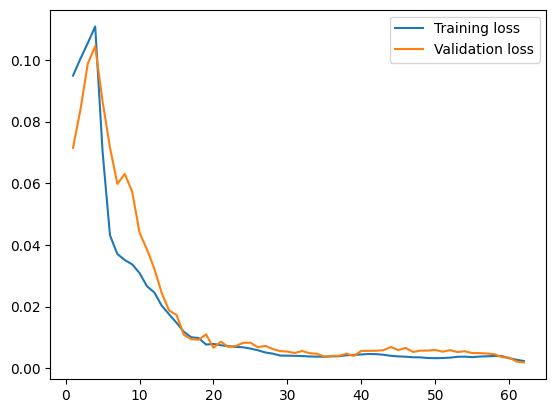

In [626]:
x = np.arange(1, len(train_hist)+1)

# optional smoothing for nicer curves
def smooth(arr, k=5):
    import numpy as np
    if k <= 1 or len(arr) < k: return arr
    w = np.ones(k)/k
    return np.convolve(arr, w, mode='same')

plt.plot(x, smooth(train_hist, k=7), label="Training loss")
plt.plot(x, smooth(val_hist, k=7), label="Validation loss")
plt.legend()
plt.show()

Evaluate model performance

In [ ]:
# Evaluate the model and calculate RMSE and R² score on VALIDATION set
model_2.eval()
with torch.no_grad():
    val_predictions = []
    for batch_X_val in X_val:
        batch_X_val = batch_X_val.to(device).unsqueeze(0)
        val_predictions.append(model_2(batch_X_val).detach().cpu().numpy().flatten()[0])

val_predictions = np.array(val_predictions)
rmse = np.sqrt(mean_squared_error(y_val.detach().cpu().numpy(), val_predictions))
r2 = r2_score(y_val.detach().cpu().numpy(), val_predictions)
print(f'Validation RMSE: {rmse:.4f}')
print(f'Validation R² Score: {r2:.4f}')

Validation RMSE: 0.0244
Validation R² Score: -0.6329
Test RMSE: 0.1188
Test R² Score: -2.8854


Plot actual vs predicted values

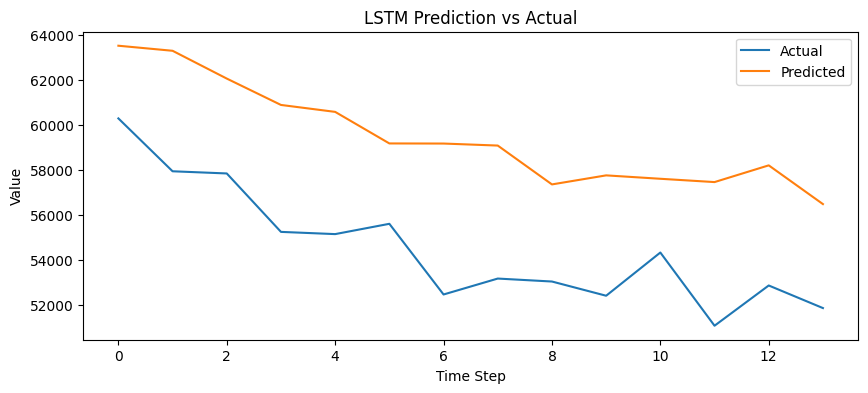

In [656]:
model_2.eval()  
with torch.no_grad():  
  predictions = model_2(X_test).squeeze().numpy() # Predict on test set  

# Inverse transform to original scale  
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))  
predictions_inv = scaler.inverse_transform(predictions.reshape(-1, 1))  

# Plot actual vs predicted  
plt.figure(figsize=(10, 4))  
plt.plot(y_test_inv, label='Actual')  
plt.plot(predictions_inv, label='Predicted')  
plt.title("LSTM Prediction vs Actual")  
plt.xlabel("Time Step")  
plt.ylabel("Value")  
plt.legend()  
plt.show()

Forecast predictions

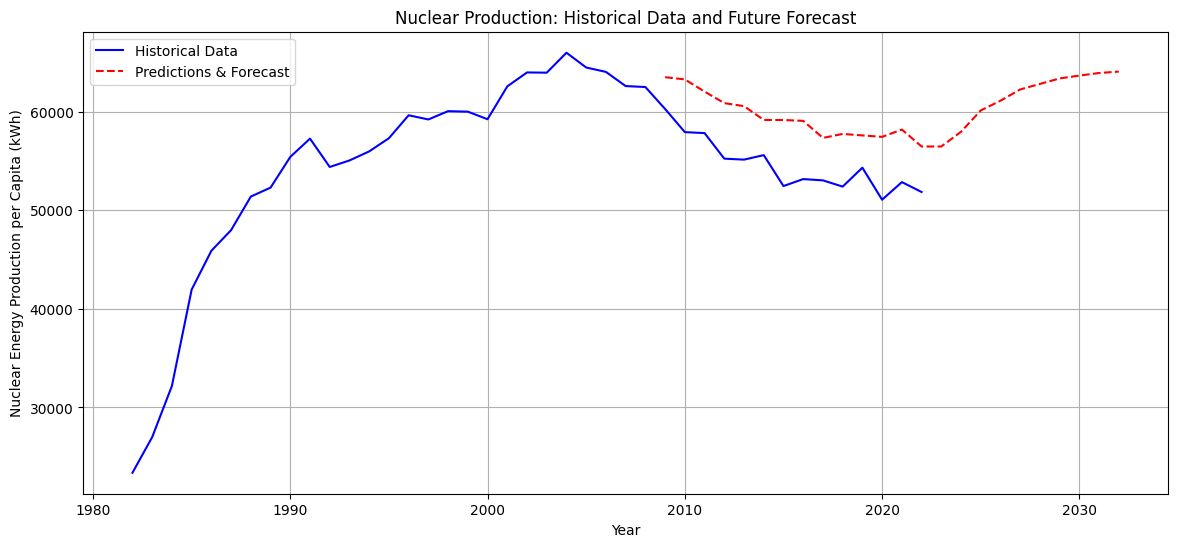

In [657]:
num_forecast_steps = 10
sequence_to_plot = X_test.squeeze().cpu().numpy()

# Ensure historical_data is at least 1D for sequence_length=1
if sequence_to_plot.ndim == 1:
    historical_data = sequence_to_plot[-1:].copy()  # Keep as 1D array with shape (1,)
else:
    historical_data = sequence_to_plot[-1].copy()

# Generate forecast values (on scaled space)
forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        hist_tensor = torch.as_tensor(historical_data).reshape(1, -1, input_size).float().to(device)
        pred_scaled = model_2(hist_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(pred_scaled)
        # For sequence_length=1, just update the single value
        if len(historical_data) == 1:
            historical_data[0] = pred_scaled
        else:
            historical_data = np.roll(historical_data, shift=-1)
            historical_data[-1] = pred_scaled

# Get test predictions (scaled) and inverse transform both test preds and forecast
model_2.eval()
with torch.no_grad():
    test_predictions_scaled = model_2(X_test).cpu().numpy().reshape(-1, 1)

test_pred_inv = scaler.inverse_transform(test_predictions_scaled).flatten()
forecast_inv = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()

# Build prediction dates: use the last len(test_pred_inv) historic dates, then future dates
hist_dates = test_data.index[-len(test_pred_inv):]
future_dates = pd.date_range(start=hist_dates[-1] + pd.DateOffset(years=1),
                             periods=num_forecast_steps,
                             freq='YS')
prediction_dates = pd.DatetimeIndex(np.concatenate([hist_dates.values, future_dates.values]))

# Combine predictions and assert lengths match
all_predictions = np.concatenate([test_pred_inv, forecast_inv])
assert len(prediction_dates) == len(all_predictions), f"dates:{len(prediction_dates)} preds:{len(all_predictions)}"

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_forecast_global.index, df_forecast_global['nuclear_elec_per_capita'], label='Historical Data', color='blue')
plt.plot(prediction_dates, all_predictions, label='Predictions & Forecast', color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Nuclear Energy Production per Capita (kWh)')
plt.title('Nuclear Production: Historical Data and Future Forecast')
plt.legend()
plt.grid(True)
plt.show()

Save the model

In [658]:
# Save the model state dictionary and hyperparameters
model_save_path = './models/lstm_nuclear_forecast.pth'
model_config = {
    'state_dict': model_2.state_dict(),
    'hyperparameters': {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'output_size': output_size,
        'dropout': dropout
    },
    'scaler': scaler
}

# Save the model
torch.save(model_config, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./models/lstm_nuclear_forecast.pth


This model struggles to predict nuclear power production accurately. Nuclear power has shown a decrease in production starting around 2002-2003. The current model overestimates nuclear power production from 2008-2022 compared to the actual data, yet still shows a downward trend. Acccording to the model, nuclear power production is set to increase again over the next decade, however this model needs further improvements before the predictions can be trusted. 

#### Solar

Let's start again with solar production. Start by prepping the data:

New solar model using log-deltas. This model is slightly different to the previous models as solar production shows an exponential growth over recent years. To optimise the model, we will use log-delta growth (log-transform values and calculate change in growth) as the target. In addition, we will apply caps (gradient clipping) and a damping term to improve the forecasts by limiting the exponential growth capability, and mild recency weights to avoid over-emphasizing recent spikes.

In [ ]:
holdout_years = 10 #number of years to keep for testing
train_data = df_forecast_global.iloc[:-holdout_years].iloc[:, 3:4]  # solar_elec_per_capita
test_data  = df_forecast_global.iloc[-holdout_years:].iloc[:, 3:4]

print("Train/Test shapes:", train_data.shape, test_data.shape)

# Log-transform levels to linearize growth
train_log = np.log1p(train_data.solar_elec_per_capita.values).reshape(-1)
test_log  = np.log1p(test_data.solar_elec_per_capita.values).reshape(-1)

# Build log-deltas: d_t = L_t - L_{t-1}; keep first delta as 0 for alignment
train_delta = np.diff(train_log, prepend=train_log[0])
test_delta  = np.diff(test_log,  prepend=test_log[0])

# Scale deltas (stationary)
scaler_delta = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_delta.fit_transform(train_delta.reshape(-1, 1))
scaled_test  = scaler_delta.transform(test_delta.reshape(-1, 1))

# Sequences on deltas
sequence_length = 5
X_train, y_train = create_sequences(scaled_train, sequence_length)
X_test,  y_test  = create_sequences(scaled_test,  sequence_length)
print("X_train, y_train, X_test, y_test:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Caps for realistic growth from training distribution (log units)
neg_cap = np.quantile(train_delta, 0.10)  # 10th percentile (downside)
pos_cap = np.quantile(train_delta, 0.90)  # 90th percentile (upside)

# Forecast damping to prevent compounding explosion (apply per-step)
gamma = 0.90  # 0.85–0.95 reasonable

Train/Test shapes: (31, 1) (10, 1)
X_train, y_train, X_test, y_test: torch.Size([26, 5, 1]) torch.Size([26, 1]) torch.Size([5, 5, 1]) torch.Size([5, 1])


In [ ]:
#Train LSTM on deltas

batch_size = 8
num_epochs = 200
lr = 0.001
num_layers = 1
hidden_size = 64
dropout = 0.1
weight_decay = 1e-3  # stronger L2 to avoid overfit on small data

loss_fn = nn.MSELoss(reduction='none')

model_2 = LSTMModel_2(input_size, hidden_size, num_layers, output_size, dropout).to(device)
optimizer = optim.Adam(model_2.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=12, min_lr=1e-6)

# time-based split inside train for validation
val_frac = 0.2
val_n = max(1, int(len(X_train) * val_frac))
train_n = len(X_train) - val_n
X_tr, y_tr = X_train[:train_n], y_train[:train_n]
X_val, y_val = X_train[train_n:], y_train[train_n:]

# mild recency weights (avoid over-emphasizing recent spikes)
w_tr = torch.linspace(0.7, 1.3, steps=len(X_tr)).unsqueeze(1).to(torch.float32)
train_loader = DataLoader(TensorDataset(X_tr, y_tr, w_tr), batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(TensorDataset(X_val, y_val),       batch_size=batch_size, shuffle=False)

best_val, best_state = float('inf'), None
patience = 25
epochs_no_improve = 0
train_hist, val_hist = [], []

for epoch in range(num_epochs):
    model_2.train()
    tot = 0.0
    for bx, by, bw in train_loader:
        bx, by, bw = bx.to(device), by.to(device), bw.to(device)
        pred = model_2(bx)              # (B,1) predicts next delta (scaled)
        elem = loss_fn(pred, by)        # per-sample loss
        w = bw.squeeze(-1)
        loss = (elem.squeeze(-1) * w).sum() / (w.sum() + 1e-8)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_2.parameters(), 1.0)
        optimizer.step()
        tot += loss.item()
    train_hist.append(tot / max(1, len(train_loader)))

    # validation
    model_2.eval()
    vtot = 0.0
    with torch.no_grad():
        for vb, vy in val_loader:
            vb, vy = vb.to(device), vy.to(device)
            pv = model_2(vb)
            vtot += loss_fn(pv, vy).mean().item()
    avg_val = vtot / max(1, len(val_loader))
    val_hist.append(avg_val)
    scheduler.step(avg_val)

    if avg_val < best_val - 1e-7:
        best_val = avg_val
        best_state = {k: v.detach().cpu().clone() for k, v in model_2.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at {epoch+1}, best val {best_val:.6f}")
        break

if best_state is not None:
    model_2.load_state_dict(best_state)
print(f"Training complete. Best validation loss: {best_val:.6f}")

c:\Users\User\OneDrive\Documents\Code Institute Data Analytics and AI\Capstone project - renewables\global_renewable_energy_analysis\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Early stopping at 34, best val 0.152515
Training complete. Best validation loss: 0.152515


Solar Test RMSE (kWh): 4534.425, R²: -0.794


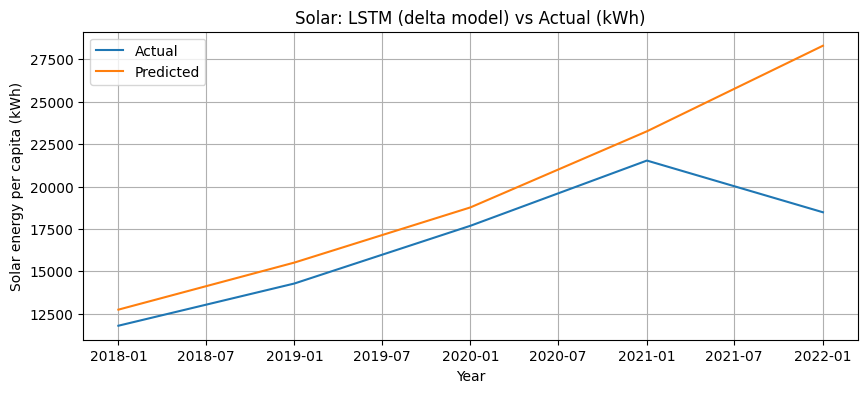

In [864]:
# --- Evaluate in original kWh and produce a damped forecast ---

model_2.eval()

# Predict next-delta (scaled) for test, invert to log-delta
with torch.no_grad():
    pred_delta_scaled = model_2(X_test.to(device)).cpu().numpy().reshape(-1, 1)
pred_delta_log = scaler_delta.inverse_transform(pred_delta_scaled).reshape(-1)

# For each target time step, base log-level is last log before the next-delta
base_logs_test = test_log[sequence_length-1:-1]  # aligns with y_test
y_pred_log_level = base_logs_test + pred_delta_log
y_true_log_level = test_log[sequence_length:]    # actual next log-level

# Back to kWh
y_pred = np.expm1(y_pred_log_level)
y_true = np.expm1(y_true_log_level)
eval_dates = test_data.index[sequence_length:]

# Metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)
print(f"Solar Test RMSE (kWh): {rmse:.3f}, R²: {r2:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 4))
plt.plot(eval_dates, y_true, label='Actual')
plt.plot(eval_dates, y_pred, label='Predicted')
plt.title("Solar: LSTM (delta model) vs Actual (kWh)")
plt.xlabel("Year")
plt.ylabel("Solar energy per capita (kWh)")
plt.legend()
plt.grid(True)
plt.show()


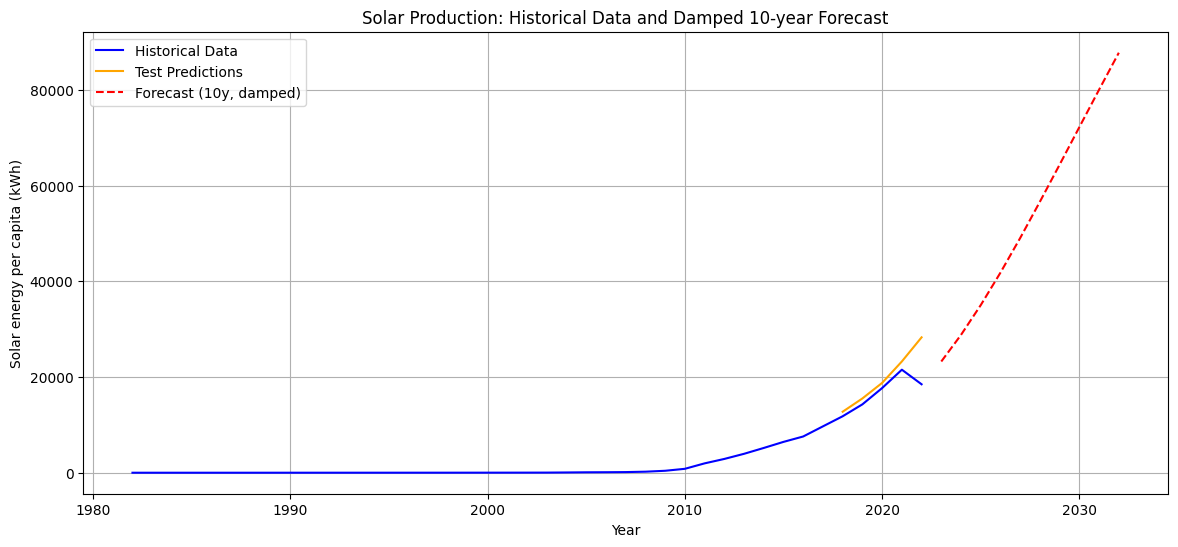

In [869]:
# --- 10-year forecast with clipping and damping in log space ---
forecast_horizon = 10

# Start with last observed log-level and last delta window (scaled)
scaled_all = np.vstack([scaled_train, scaled_test])  # deltas (scaled)
win = scaled_all[-sequence_length:].copy().reshape(sequence_length, 1)
last_log = test_log[-1]  # last observed log-level

forecast_logs = []
with torch.no_grad():
    for h in range(forecast_horizon):
        inp = torch.tensor(win, dtype=torch.float32).unsqueeze(0).to(device)   # (1, seq_len, 1)
        next_delta_scaled = model_2(inp).cpu().numpy()[0, 0]
        next_delta_log = scaler_delta.inverse_transform([[next_delta_scaled]])[0, 0]

        # Cap to realistic growth range and apply damping per step
        next_delta_log = np.clip(next_delta_log, neg_cap, pos_cap)
        next_delta_log *= (gamma ** (h + 1))

        # Update level and window
        last_log = last_log + next_delta_log
        forecast_logs.append(last_log)

        next_delta_scaled_for_window = scaler_delta.transform([[next_delta_log]])[0, 0]
        win = np.vstack([win[1:], [[next_delta_scaled_for_window]]])

# Back to kWh and build dates
forecast_kwh = np.expm1(np.array(forecast_logs))
future_dates = pd.date_range(start=test_data.index[-1] + pd.DateOffset(years=1),
                             periods=forecast_horizon, freq='YS')

# Plot historical + predictions + forecast
plt.figure(figsize=(14, 6))
plt.plot(df_forecast_global.index, df_forecast_global['solar_elec_per_capita'], label='Historical Data', color='blue')
plt.plot(eval_dates, y_pred, label='Test Predictions', color='orange')
plt.plot(future_dates, forecast_kwh, label='Forecast (10y, damped)', color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Solar energy per capita (kWh)')
plt.title('Solar Production: Historical Data and Damped 10-year Forecast')
plt.legend()
plt.grid(True)
plt.show()

save model

In [870]:
# Save model and scaler used for deltas
model_save_path = './models/lstm_solar_forecast.pth'
model_config = {
    'state_dict': model_2.state_dict(),
    'hyperparameters': {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'output_size': output_size,
        'dropout': dropout
    },
    'scaler': scaler_delta,             # note: delta-scaler
    'delta_model': True,
    'delta_caps': (float(neg_cap), float(pos_cap)),
    'gamma': float(gamma)
}
torch.save(model_config, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./models/lstm_solar_forecast.pth


#### Wind

The final model will be for wind production. This model uses a similar approach to that solar model, with log-delta targets, gradient clipping, recency weights and damping.

In [987]:
from sklearn.preprocessing import StandardScaler

holdout_years = 10
train_data_w = df_forecast_global.iloc[:-holdout_years].iloc[:, 4:5]  # wind_elec_per_capita
test_data_w  = df_forecast_global.iloc[-holdout_years:].iloc[:, 4:5]

print("Wind Train/Test shapes:", train_data_w.shape, test_data_w.shape)

# Log-levels and log-deltas
train_log_w = np.log1p(train_data_w.wind_elec_per_capita.values).reshape(-1)
test_log_w  = np.log1p(test_data_w.wind_elec_per_capita.values).reshape(-1)
train_delta_w = np.diff(train_log_w, prepend=train_log_w[0])
test_delta_w  = np.diff(test_log_w,  prepend=test_log_w[0])

# Scale deltas on TRAIN only (StandardScaler preserves near-zero behavior better than MinMax)
sc_delta_w = StandardScaler().fit(train_delta_w.reshape(-1, 1))
scaled_train_w = sc_delta_w.transform(train_delta_w.reshape(-1, 1))
scaled_test_w  = sc_delta_w.transform(test_delta_w.reshape(-1, 1))

# Sequences
sequence_length = 3
X_train, y_train = create_sequences(scaled_train_w, sequence_length)
X_test,  y_test  = create_sequences(scaled_test_w,  sequence_length)
print("Wind X_train, y_train, X_test, y_test:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Growth caps (log units) and damping (used in forecast only)
neg_cap_w = np.quantile(train_delta_w, 0.10)
pos_cap_w = np.quantile(train_delta_w, 0.90)
gamma_w = 0.92


Wind Train/Test shapes: (31, 1) (10, 1)
Wind X_train, y_train, X_test, y_test: torch.Size([28, 3, 1]) torch.Size([28, 1]) torch.Size([7, 3, 1]) torch.Size([7, 1])


Fit the model

In [ ]:
# LSTM on wind deltas 
batch_size = 20
num_epochs = 300
lr = 0.001
num_layers = 1
hidden_size = 128
dropout = 0.1
weight_decay = 1e-3

# use reduction='none' to apply weights
#loss_fn = nn.SmoothL1Loss(reduction='none')  # or 
loss_fn = nn.MSELoss(reduction='none')

model_2 = LSTMModel_2(input_size, hidden_size, num_layers, output_size, dropout).to(device)
optimizer = optim.Adam(model_2.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=12, min_lr=1e-6)

# time-based validation (no shuffle)
val_frac = 0.2
val_n = max(1, int(len(X_train) * val_frac))
X_tr, y_tr = X_train[:-val_n], y_train[:-val_n]
X_val, y_val = X_train[-val_n:], y_train[-val_n:]

# Recency weights emphasize latest training windows (helps fit 2020+ plateau)
w_tr = torch.linspace(1.0, 2.0, steps=len(X_tr)).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_tr, y_tr, w_tr), batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(TensorDataset(X_val, y_val),       batch_size=batch_size, shuffle=False)

best_val, best_state = float('inf'), None
patience, no_improve = 30, 0

for epoch in range(num_epochs):
    model_2.train()
    tot = 0.0
    for bx, by, bw in train_loader:
        bx, by, bw = bx.to(device), by.to(device), bw.to(device)
        pred = model_2(bx)                  # (B,1) next-step delta (scaled)
        elem = loss_fn(pred, by)            # (B,1)
        loss = (elem * bw).sum() / (bw.sum() + 1e-8)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_2.parameters(), 1.0)
        optimizer.step()
        tot += loss.item()

    # validation (unweighted MSE for selection)
    model_2.eval()
    vtot = 0.0
    with torch.no_grad():
        for vb, vy in val_loader:
            vb, vy = vb.to(device), vy.to(device)
            pv = model_2(vb)
            vtot += nn.MSELoss(reduction='mean')(pv, vy).item()
    avg_val = vtot / max(1, len(val_loader))
    scheduler.step(avg_val)

    if avg_val < best_val - 1e-7:
        best_val = avg_val
        best_state = {k: v.detach().cpu().clone() for k, v in model_2.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
    if no_improve >= patience:
        print(f"Early stopping at {epoch+1}, best val {best_val:.6f}")
        break

if best_state is not None:
    model_2.load_state_dict(best_state)
print(f"Wind training complete. Best validation loss: {best_val:.6f}")


c:\Users\User\OneDrive\Documents\Code Institute Data Analytics and AI\Capstone project - renewables\global_renewable_energy_analysis\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Early stopping at 46, best val 0.574649
Wind training complete. Best validation loss: 0.574649


Evaluate model

Wind Test RMSE (kWh): 6377.775, R²(kWh): -0.754, R²(log): -0.282


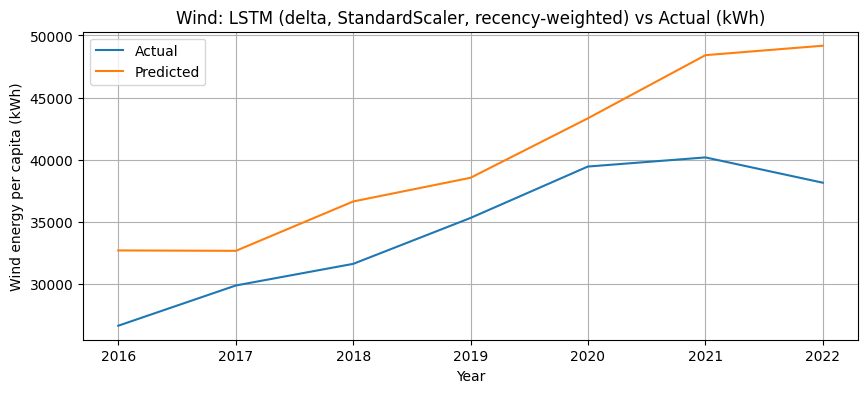

In [995]:
model_2.eval()
with torch.no_grad():
    pred_delta_scaled_w = model_2(X_test.to(device)).cpu().numpy().reshape(-1, 1)

pred_delta_log_w = sc_delta_w.inverse_transform(pred_delta_scaled_w).reshape(-1)
base_logs_test_w = test_log_w[sequence_length-1:-1]
y_pred_log_level_w = base_logs_test_w + pred_delta_log_w
y_true_log_level_w = test_log_w[sequence_length:]

# back to kWh
y_pred_w = np.expm1(y_pred_log_level_w)
y_true_w = np.expm1(y_true_log_level_w)
eval_dates_w = test_data_w.index[sequence_length:]

rmse_w = np.sqrt(mean_squared_error(y_true_w, y_pred_w))
r2_w   = r2_score(y_true_w, y_pred_w)
r2_w_log = r2_score(y_true_log_level_w, y_pred_log_level_w)
print(f"Wind Test RMSE (kWh): {rmse_w:.3f}, R²(kWh): {r2_w:.3f}, R²(log): {r2_w_log:.3f}")

plt.figure(figsize=(10, 4))
plt.plot(eval_dates_w, y_true_w, label='Actual')
plt.plot(eval_dates_w, y_pred_w, label='Predicted')
plt.title("Wind: LSTM (delta, StandardScaler, recency-weighted) vs Actual (kWh)")
plt.xlabel("Year")
plt.ylabel("Wind energy per capita (kWh)")
plt.legend(); plt.grid(True); plt.show()

Forecast future wind production

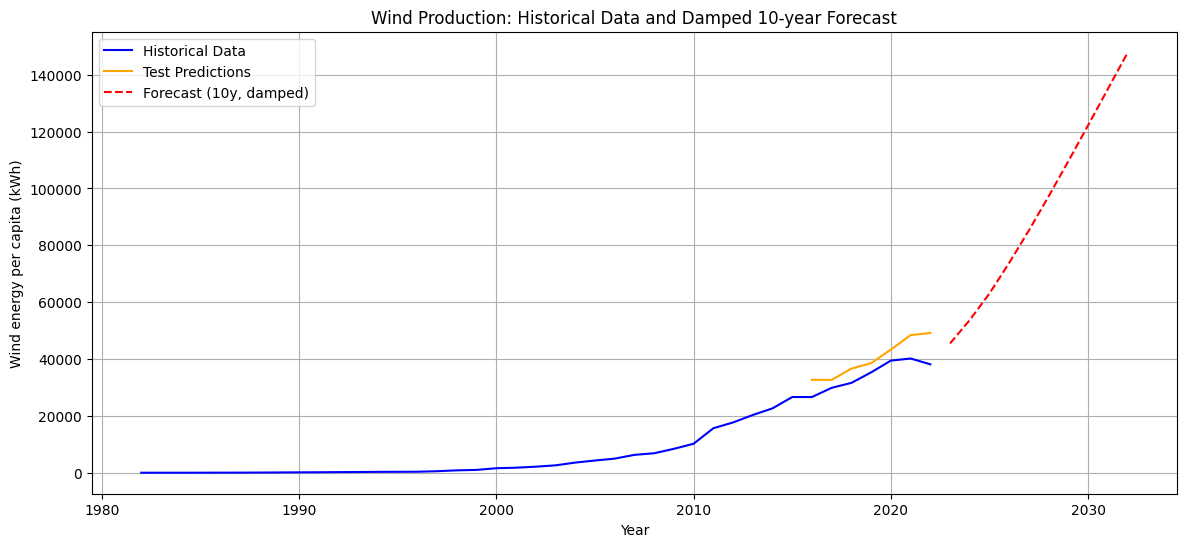

In [997]:
forecast_horizon = 10
scaled_all_w = np.vstack([scaled_train_w, scaled_test_w])
win = scaled_all_w[-sequence_length:].copy().reshape(sequence_length, 1)

# Use last ACTUAL log-level (not predicted) to avoid compounding test error into forecast
last_log_w = test_log_w[-1]  # ← last actual observed value

forecast_logs_w = []
with torch.no_grad():
    for h in range(forecast_horizon):
        inp = torch.tensor(win, dtype=torch.float32).unsqueeze(0).to(device)
        next_delta_scaled = model_2(inp).cpu().numpy()[0, 0]
        next_delta_log = sc_delta_w.inverse_transform([[next_delta_scaled]])[0, 0]
        next_delta_log = np.clip(next_delta_log, neg_cap_w, pos_cap_w)
        next_delta_log *= (gamma_w ** (h + 1))
        last_log_w = last_log_w + next_delta_log
        forecast_logs_w.append(last_log_w)
        next_delta_scaled_for_window = sc_delta_w.transform([[next_delta_log]])[0, 0]
        win = np.vstack([win[1:], [[next_delta_scaled_for_window]]])

forecast_kwh_w = np.expm1(np.array(forecast_logs_w))
future_dates_w = pd.date_range(start=test_data_w.index[-1] + pd.DateOffset(years=1),
                               periods=forecast_horizon, freq='YS')

plt.figure(figsize=(14, 6))
plt.plot(df_forecast_global.index, df_forecast_global['wind_elec_per_capita'], label='Historical Data', color='blue')
plt.plot(eval_dates_w, y_pred_w, label='Test Predictions', color='orange')
plt.plot(future_dates_w, forecast_kwh_w, label='Forecast (10y, damped)', color='red', linestyle='--')
plt.xlabel('Year'); plt.ylabel('Wind energy per capita (kWh)')
plt.title('Wind Production: Historical Data and Damped 10-year Forecast')
plt.legend(); plt.grid(True); plt.show()

Save model

In [998]:
# Save model and scaler used for deltas
model_save_path = './models/lstm_wind_forecast.pth'
model_config = {
    'state_dict': model_2.state_dict(),
    'hyperparameters': {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'output_size': output_size,
        'dropout': dropout
    },
    'scaler': scaler_delta,             # note: delta-scaler
    'delta_model': True,
    'delta_caps': (float(neg_cap), float(pos_cap)),
    'gamma': float(gamma)
}
torch.save(model_config, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./models/lstm_wind_forecast.pth


The wind LSTM model slightly overestimates wind production for 2016-2022, but does pick up the levelling-off that occurs in the last couple of years. Global wind production has been increasing gradually since 2000 up to 40,000 kWh in 2022. Over the next decade, global wind production in predicted to keep increasing up to approximately 140,000 kWh by 2032.

## Conclusions

**H1:** The analyses provided above shows that growth in fossil and renewable energy is not linked to a country's GDP (in terms of averages per country over the last 5 years). Some countrys show more overall growth in fossil/renewables than others. For instance, Indonesia and Vietnam have shown the highest average growth in fossil fuel over the last 5 years (between 5-6% per annum on average). Indonesia also has some of the higest average annual growth in renewables of over 20%, along with countries such as Israel, Iraq and Netherlands.

**H2:** Different sets of countries were identified as leaders in the transition to green energy, depending on the type of renewable (based on the average share of energy production per country over the last 5 years). The leaders for each energy type were; The Cook Islands (Solar), Denmark (Wind), Eswatiti (Biofuel), France (Nuclear). Multiple countries were 100% reliant on hydropower for their energy production (Bhutan, Central African Republic, Lesotho, Paraguay, Democratic Republic of Congo, Albania and Nepal).

**H3:** There has been an increase in renewable energy production over the last two decades, with this growth set to continue over the next 10 years. The models built here predict growth in each renewable type, despite sudden drops in production for all renewables between 2021-2022 (possibly covid-related). Hydropower is dominant, with production set to increase to approximately 240,000 kWh by 2032. Wind production is predicted to overtake nuclear power, with estimates of 150,000 kWh for wind vs 63,000 kWh for nuclear in 2032. This is due to the decrease in nuclear production since the early 2000's, which will take the next 10 years to recover. Biofuel production has been steadily increasing since 1990, and will continue this gradual increase to approxiamte 25,000 kWh by 2032. In contrast, solar production has grown exponentially since 2010 and will overtake biofuel production with estimates of 90,000 kWh production by 2032.

## Further Insights

The link between growth in fossil/renewables and GDP (H1) could be further explored by testing if this relationship depends on sub-region. This could highlight the differences between developed and emerging economies in terms of the link between energy consumption/growth and GDP.

The forecast models (H3) could provide further insights by adding the following to the analyses:
- Further model optimisation to capture most recent trends.
- Add more independent variables to the models to aid predictions, such as predicting growth per sub-region.
- Combine growth in production of all renewables into a multiple time series to improve forecasts.